# Inizio

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2

#i grafici verranno visualizzati direttamente sotto le loro celle, inoltre è attivo l'autoreload del kernel

In [2]:
import sys
sys.path.append("C:\\Users\\celin\\AppData\\Local\\Programs\\Python\\Python312")
sys.path.append("/Users/francescoparino/Researchs/Mac2Mic/Util/")
sys.path.append("C:\\Users\\celin\\Desktop\\polito\\magistrale\\tesi\\flu_2023")
sys.path.append("./")
#queste istruzioni servono a dire a Python in quali percorsi bisogna cercare i moduli

In [3]:
#importiamo i moduli che ci servono
import pandas as pd #si usa per manipolare e analizzare dati: file excel, csv ecc.
import numpy as np #funzioni, array multidimensionali, calcoli complessi
from numpy import ones
import scipy as spy #si usa assieme a numpy: calcola integrali, minimizza e massimizza funzionali, trasformate fourier ecc
import os #permette di manipolare file
import copy
import pickle
import itertools
import datetime #fornisce classi e funzioni per manipolare date e orari
import matplotlib #si usa per creare grafici


from glob import glob #glob lo usiamo per dire a python che file ci serve, dando come input il percorso

import seaborn as sns #seaborn aggiunge opzioni grafiche a matplotlib
blues = np.array(sns.light_palette("blue"))[[-4,-1]]
purples = np.array(sns.light_palette("purple"))[[-4,-1]]

import matplotlib.patches as mpatches #oggetti geometrici (patches) per i grafici
from collections import Counter, defaultdict #fornisce delle classi utili a manipolare dati aggregati
from itertools import combinations

from tqdm import tqdm_notebook #taqaddum, fornisce barra di avanzamento per i cicli for

import collections, functools, operator 
from bidict import bidict
from sklearn.decomposition import NMF
from matplotlib.colors import LogNorm

from multiprocessing import Pool

# LETTURA DATI INFLUCAST

In [11]:
'''
Lettura dati reali CON approssimazione nazionale per le province mancanti
'''


import os
import pandas as pd

folder_path = 'C:\\Users\\celin\\Desktop\\polito\\magistrale\\tesi\\dati_reali_24-25\\2024_47'

weekly_cases_by_region = {}
latest_files = {}

# Raccogli i file più recenti per ogni regione
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        base_name = file_name[:-4]
        region_name, year_week, target = base_name.split('-')
        year, week = map(int, year_week.split('_'))
        
        if region_name not in latest_files or (year, week) > (latest_files[region_name]['year'], latest_files[region_name]['week']):
            latest_files[region_name] = {'file_name': file_name, 'year_week': year_week, 'year': year, 'week': week}

# Leggi i file regionali e raccogli i dati settimanali
for region_name, file_info in latest_files.items():
    file_name = file_info['file_name']
    file_path = os.path.join(folder_path, file_name)
    print(f"Elaborazione del file per la regione: {region_name}, settimana: {file_info['week']} del {file_info['year']}")
    
    df = pd.read_csv(file_path)
    
    if region_name not in weekly_cases_by_region:
        weekly_cases_by_region[region_name] = {}
    
    for _, row in df.iterrows():
        week = f"{int(row['anno'])}_W{int(row['settimana']):02d}"
        cases = row['incidenza']
        weekly_cases_by_region[region_name][week] = cases

# Debug: Stampa il dizionario settimanale dei casi
print("Dati settimanali iniziali per regione:", weekly_cases_by_region)


week_of_interest = "2024_W47"  # Sostituisci con la settimana nel nome della cartella di interesse

# carichiamo l'incidenza reale per ogni regione
national_file = os.path.join(folder_path, "italia-2024_47-ILI.csv")
national_df = pd.read_csv(national_file)
incidenza_nazionale = national_df['incidenza'].iloc[-1]  # Ultima settimana

for region_name, weeks_data in weekly_cases_by_region.items():
    # se influcast non ci ha inviato dati per quella regione
    if not weeks_data:
        print(f"Attenzione: Nessun dato disponibile per {region_name}. Verrà usata l'incidenza nazionale.")
        weekly_cases_by_region[region_name] = {week_of_interest: incidenza_nazionale}
        continue

    # se per quella settimana non ci sono dati
    if week_of_interest not in weeks_data:
        print(f"Attenzione: Nessun dato per la settimana {week_of_interest} in {region_name}. Verrà usata l'incidenza nazionale.")
        weekly_cases_by_region[region_name][week_of_interest] = incidenza_nazionale

# Debug: Verifica il dizionario dopo l'aggiornamento
print("Dati settimanali aggiornati per regione:", weekly_cases_by_region)

# Normalizzazione dei nomi delle regioni
def normalize_region_name(region_name):
    normalized_name = region_name.lower().replace("_", " ").strip()
    return normalized_name

region_name_mapping = {
    "provincia autonoma di bolzano": "P.A. Bolzano",
    "provincia autonoma di trento": "P.A. Trento",
    "valle d'aosta": "valle d aosta",
    "emilia-romagna": "emilia romagna",
    "italia": "Italia",
    "pa trento": "trentino"
}

pop_df = pd.read_csv("popREG2.csv")
pop_df['Regione'] = pop_df['Regione'].apply(normalize_region_name)
pop_df['Regione'] = pop_df['Regione'].replace(region_name_mapping)
pop_dict = pop_df.set_index('Regione')['PopolazioneRegionale'].to_dict()

normalized_weekly_cases_by_region = {
    normalize_region_name(region_name): weeks_data 
    for region_name, weeks_data in weekly_cases_by_region.items()
}
normalized_weekly_cases_by_region = {
    region_name_mapping.get(region_name, region_name): weeks_data 
    for region_name, weeks_data in normalized_weekly_cases_by_region.items()
}

# Calcola i casi totali provinciali
for region_name, weeks_data in normalized_weekly_cases_by_region.items():
    if region_name not in pop_dict:
        continue
    
    population_region = pop_dict[region_name]
    for week, incidence_per_1000 in weeks_data.items():
        estimated_cases = incidence_per_1000 * population_region / 1000
        normalized_weekly_cases_by_region[region_name][week] = estimated_cases

# Distribuzione provinciale dei casi
final_df = pd.DataFrame()
for region_name, weekly_cases in normalized_weekly_cases_by_region.items():
    region_df = pop_df[pop_df['Regione'].str.strip().str.lower() == region_name.strip().lower()]
    if region_df.empty:
        continue
    
    for week, total_cases in weekly_cases.items():
        region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
        region_df['Settimana'] = week
        final_df = pd.concat([final_df, region_df[['Territorio', 'Settimana', 'CasiDistribuiti']]], ignore_index=True)

# Salva il file finale
final_df.to_csv('casi_distribuiti_province.csv', index=False)

import pandas as pd
import numpy as np

risultati = pd.read_csv('risultati1.csv')
dati_reali = pd.read_csv('casi_distribuiti_province.csv')

risultati['Settimana'] = pd.to_datetime(risultati['Date']).dt.isocalendar().week
risultati['Anno'] = pd.to_datetime(risultati['Date']).dt.year
risultati['Settimana_Anno'] = risultati['Anno'].astype(str) + '_W' + risultati['Settimana'].astype(str)

dati_reali['Anno'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[0]))
dati_reali['Settimana_Numero'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[1]))

def espandi_settimana_a_giorni(df):
    expanded_rows = []
    for _, row in df.iterrows():
        inizio_settimana = pd.to_datetime(f'{row["Anno"]}-W{int(row["Settimana_Numero"])}-1', format='%Y-W%W-%w')
        for i in range(7):
            giorno = inizio_settimana + pd.Timedelta(days=i)
            expanded_rows.append({
                'Territorio': row['Territorio'],
                'Data': giorno,
                'Settimana_Numero': row['Settimana_Numero'],
                'CasiDistribuiti': row['CasiDistribuiti']  # non distribuiamo qui
            })
    return pd.DataFrame(expanded_rows)

dati_reali_giornalieri = espandi_settimana_a_giorni(dati_reali)

def normalize_province_name(province_name):
    return province_name.strip().lower().replace("'", "").replace(" ", "").replace("-", "")

risultati['Provincia_Normalizzata'] = risultati['Province'].apply(normalize_province_name)
dati_reali_giornalieri['Provincia_Normalizzata'] = dati_reali_giornalieri['Territorio'].apply(normalize_province_name)

dati_reali_giornalieri = dati_reali_giornalieri.sort_values(['Provincia_Normalizzata', 'Data'])
dati_reali_giornalieri['CasiDistribuiti'] = dati_reali_giornalieri.groupby('Provincia_Normalizzata')['CasiDistribuiti'].transform(lambda x: x.interpolate(method='linear'))

risultati['Date'] = pd.to_datetime(risultati['Date'])
dati_reali_giornalieri['Data'] = pd.to_datetime(dati_reali_giornalieri['Data'])

confronto = pd.merge(risultati, dati_reali_giornalieri, left_on=['Provincia_Normalizzata', 'Date'], right_on=['Provincia_Normalizzata', 'Data'], how='inner')

confronto.to_csv('confronto_risultati_reali_simulati_giornaliero.csv', index=False)

confronto.head()

Elaborazione del file per la regione: abruzzo, settimana: 47 del 2024
Elaborazione del file per la regione: basilicata, settimana: 47 del 2024
Elaborazione del file per la regione: calabria, settimana: 45 del 2024
Elaborazione del file per la regione: campania, settimana: 47 del 2024
Elaborazione del file per la regione: emilia_romagna, settimana: 47 del 2024
Elaborazione del file per la regione: friuli_venezia_giulia, settimana: 47 del 2024
Elaborazione del file per la regione: italia, settimana: 47 del 2024
Elaborazione del file per la regione: lazio, settimana: 47 del 2024
Elaborazione del file per la regione: liguria, settimana: 47 del 2024
Elaborazione del file per la regione: lombardia, settimana: 47 del 2024
Elaborazione del file per la regione: marche, settimana: 47 del 2024
Elaborazione del file per la regione: molise, settimana: 47 del 2024
Elaborazione del file per la regione: pa_bolzano, settimana: 47 del 2024
Elaborazione del file per la regione: pa_trento, settimana: 47 d

C:\Users\celin\AppData\Local\Temp\ipykernel_12804\1233919881.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
C:\Users\celin\AppData\Local\Temp\ipykernel_12804\1233919881.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['Settimana'] = week
C:\Users\celin\AppData\Local\Temp\ipykernel_12804\1233919881.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

,Date,Province,Suscettibili,Esposti,Infetti,Non Contagiosi,Rimossi,Morti,Settimana,Anno,Settimana_Anno,Provincia_Normalizzata,Territorio,Data,Settimana_Numero,CasiDistribuiti


In [ ]:
'''
Lettura dati reali SENZA approssimazione nazionale per le province mancanti


import os
import pandas as pd


folder_path = 'C:\\Users\\celin\\Desktop\\polito\\magistrale\\tesi\\2024_46'


weekly_cases_by_region = {}


latest_files = {}


for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        # Rimuovi l'estensione .csv
        base_name = file_name[:-4]
        
        # Estrai il nome della regione e anno-settimana dal nome del file
        region_name, year_week, target = base_name.split('-')
        year, week = map(int, year_week.split('_'))
        
        # Se non abbiamo ancora visto questo anno per la regione, o se questo file ha una settimana più alta, sostituiscilo
        if region_name not in latest_files or (year, week) > (latest_files[region_name]['year'], latest_files[region_name]['week']):
            latest_files[region_name] = {'file_name': file_name, 'year_week': year_week, 'year': year, 'week': week}

# only reads last week data
for region_name, file_info in latest_files.items():
    file_name = file_info['file_name']
    file_path = os.path.join(folder_path, file_name)
    print(f"Elaborazione del file per la regione: {region_name}, settimana: {file_info['week']} del {file_info['year']}")
    
    df = pd.read_csv(file_path)
    
    
    if region_name not in weekly_cases_by_region:
        weekly_cases_by_region[region_name] = {}
    
    # adds weekly data to the dict
    for _, row in df.iterrows():
        week = f"{int(row['anno'])}_W{int(row['settimana']):02d}"  
        cases = row['incidenza']
        weekly_cases_by_region[region_name][week] = cases

# debug
print("Dizionario settimanale dei casi per regione:")
print(weekly_cases_by_region)


def normalize_region_name(region_name):
    normalized_name = region_name.lower().replace("_", " ").strip()
    return normalized_name




region_name_mapping = {
    "provincia autonoma di bolzano": "P.A. Bolzano",
    "provincia autonoma di trento": "P.A. Trento",
    "valle d'aosta": "valle d aosta",
    "emilia-romagna": "emilia romagna",
    "italia": "Italia",
    "pa trento": "trentino"
}


pop_df = pd.read_csv("popREG2.csv")


pop_df['Regione'] = pop_df['Regione'].apply(normalize_region_name)

pop_df['Regione'] = pop_df['Regione'].replace(region_name_mapping)

#print("Regioni nel file popREG2.csv:", pop_df['Regione'].unique())

pop_dict = pop_df.set_index('Regione')['PopolazioneRegionale'].to_dict()

normalized_weekly_cases_by_region = {
    normalize_region_name(region_name): weeks_data 
    for region_name, weeks_data in weekly_cases_by_region.items()
}

normalized_weekly_cases_by_region = {
    region_name_mapping.get(region_name, region_name): weeks_data 
    for region_name, weeks_data in normalized_weekly_cases_by_region.items()
}



for region_name, weeks_data in normalized_weekly_cases_by_region.items():
    # Otteniamo la popolazione generale della regione
    if region_name not in pop_dict:
        #print(f"Attenzione: la popolazione della regione {region_name} non è presente nel file popREG2.csv")
        continue
    
    # Popolazione generale della regione
    population_region = pop_dict[region_name]
    
    # Debug: Stampa la popolazione e l'incidenza prima del calcolo
    #print(f"Regione: {region_name}, Popolazione: {population_region}")
    
    # Ora aggiorniamo i dati settimanali rapportandoli alla popolazione generale
    for week, incidence_per_1000 in weeks_data.items():
        # Debug: Stampa l'incidenza prima del calcolo
        #print(f"Settimana: {week}, Incidenza per 1000 abitanti: {incidence_per_1000}")
        
        # Calcoliamo il numero totale di casi nella popolazione generale
        estimated_cases = incidence_per_1000 * population_region / 1000
        
        # Debug: Stampa il numero di casi stimati
        #print(f"Settimana: {week}, Casi stimati: {estimated_cases}")
        
        # Aggiorniamo il dizionario con i casi stimati
        normalized_weekly_cases_by_region[region_name][week] = estimated_cases

#print(normalized_weekly_cases_by_region)


pop_df = pd.read_csv("popREG2.csv")

pop_df = pop_df.replace('Emilia-Romagna', 'emilia romagna')

final_df = pd.DataFrame()

normalized_weekly_cases_by_region['emilia_romagna'] = normalized_weekly_cases_by_region['emilia romagna']

for region_name, weekly_cases in normalized_weekly_cases_by_region.items():
    #print(f"Elaborazione regione: {region_name}")
    
    region_df = pop_df[pop_df['Regione'].str.strip().str.lower() == region_name.strip().lower()]
    
    if region_df.empty:
        #print(f"ATTENZIONE: Nessun dato trovato per la regione {region_name}!")
        continue
    
    for week, total_cases in weekly_cases.items():
        #print(f"Settimana: {week}, Casi totali: {total_cases}")
        
        region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
        
        region_df['Settimana'] = week
        
        final_df = pd.concat([final_df, region_df[['Territorio', 'Settimana', 'CasiDistribuiti']]], ignore_index=True)

#print(final_df)

final_df.to_csv('casi_distribuiti_province.csv', index=False)

import pandas as pd
import numpy as np

risultati = pd.read_csv('risultati1.csv')
dati_reali = pd.read_csv('casi_distribuiti_province.csv')

risultati['Settimana'] = pd.to_datetime(risultati['Date']).dt.isocalendar().week
risultati['Anno'] = pd.to_datetime(risultati['Date']).dt.year
risultati['Settimana_Anno'] = risultati['Anno'].astype(str) + '_W' + risultati['Settimana'].astype(str)

dati_reali['Anno'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[0]))
dati_reali['Settimana_Numero'] = dati_reali['Settimana'].apply(lambda x: int(x.split('_W')[1]))

def espandi_settimana_a_giorni(df):
    expanded_rows = []
    for _, row in df.iterrows():
        inizio_settimana = pd.to_datetime(f'{row["Anno"]}-W{int(row["Settimana_Numero"])}-1', format='%Y-W%W-%w')
        for i in range(7):
            giorno = inizio_settimana + pd.Timedelta(days=i)
            expanded_rows.append({
                'Territorio': row['Territorio'],
                'Data': giorno,
                'Settimana_Numero': row['Settimana_Numero'],
                'CasiDistribuiti': row['CasiDistribuiti']  # non distribuiamo qui
            })
    return pd.DataFrame(expanded_rows)

dati_reali_giornalieri = espandi_settimana_a_giorni(dati_reali)

def normalize_province_name(province_name):
    return province_name.strip().lower().replace("'", "").replace(" ", "").replace("-", "")

risultati['Provincia_Normalizzata'] = risultati['Province'].apply(normalize_province_name)
dati_reali_giornalieri['Provincia_Normalizzata'] = dati_reali_giornalieri['Territorio'].apply(normalize_province_name)

dati_reali_giornalieri = dati_reali_giornalieri.sort_values(['Provincia_Normalizzata', 'Data'])
dati_reali_giornalieri['CasiDistribuiti'] = dati_reali_giornalieri.groupby('Provincia_Normalizzata')['CasiDistribuiti'].transform(lambda x: x.interpolate(method='linear'))

risultati['Date'] = pd.to_datetime(risultati['Date'])
dati_reali_giornalieri['Data'] = pd.to_datetime(dati_reali_giornalieri['Data'])

confronto = pd.merge(risultati, dati_reali_giornalieri, left_on=['Provincia_Normalizzata', 'Date'], right_on=['Provincia_Normalizzata', 'Data'], how='inner')

confronto.to_csv('confronto_risultati_reali_simulati_giornaliero.csv', index=False)

confronto.head()

'''

Elaborazione del file per la regione: abruzzo, settimana: 46 del 2024
Elaborazione del file per la regione: basilicata, settimana: 45 del 2024
Elaborazione del file per la regione: calabria, settimana: 45 del 2024
Elaborazione del file per la regione: campania, settimana: 46 del 2024
Elaborazione del file per la regione: emilia_romagna, settimana: 46 del 2024
Elaborazione del file per la regione: friuli_venezia_giulia, settimana: 46 del 2024
Elaborazione del file per la regione: italia, settimana: 46 del 2024
Elaborazione del file per la regione: lazio, settimana: 46 del 2024
Elaborazione del file per la regione: liguria, settimana: 46 del 2024
Elaborazione del file per la regione: lombardia, settimana: 46 del 2024
Elaborazione del file per la regione: marche, settimana: 46 del 2024
Elaborazione del file per la regione: molise, settimana: 46 del 2024
Elaborazione del file per la regione: pa_bolzano, settimana: 46 del 2024
Elaborazione del file per la regione: pa_trento, settimana: 46 d

C:\Users\celin\AppData\Local\Temp\ipykernel_700\3161724980.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['CasiDistribuiti'] = region_df['rapporto'] * total_cases
C:\Users\celin\AppData\Local\Temp\ipykernel_700\3161724980.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['Settimana'] = week
C:\Users\celin\AppData\Local\Temp\ipykernel_700\3161724980.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

,Date,Province,Suscettibili,Esposti,Infetti,Non Contagiosi,Rimossi,Morti,Settimana,Anno,Settimana_Anno,Provincia_Normalizzata,Territorio,Data,Settimana_Numero,CasiDistribuiti


# Funzioni

In [36]:
from engine1 import parameters, readFluDataset1, readFluDatasetInflucast, normalizeNameProvince, aggiungiProvinceMancanti
# nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict = readFluDataset1()
flu_file = 'casi_distribuiti_province.csv'  # Inserisci il percorso del tuo file
nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict, flu_df, recent_flu_df = readFluDatasetInflucast(flu_file)
# verifichiamo di aver letto bene il file .csv coi dati reali
print("Popolazioni:", nh)
print("Matrice di flusso (Whk):", Whk)
initial_case_i = initial_case_i / (7 * 0.35)
initial_case_e = initial_case_e / (7 * 0.42)
print("Casi iniziali (I):", initial_case_i)


Popolazioni: [2243382  176576  181868  160079  365286  586113  217407  426952  126620
  214073  280625  853939  218702  871334  586795  336127  180766 3035443
 1086890 1238075  535666  223659  357581  408187  504708  524877  899817
  858732  209720  876051  846275  920895  242167  310611  534944  139914
  232311  284440  427164  517772  685822  976053  352856  384428  390677
  322028  199437  387625  287645  972232  245299  334870  410728  343298
  266522  220124  655006  228209  362676  473642  319375  210182  312674
  154909 3995250  544887  492302  298087  306177  314391  387761   86989
  226156  905188  284560 3053247  428855 1092574  625657 1246742  584229
  400504  801170  377512  200050  713869  170718  359783  163216  550832
  429537 1242560  649320  272906  173377 1078045  307697  327751  159103
  549893  174813  391770  446520  399892  163678  840358  437421]
Matrice di flusso (Whk): [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.     

In [37]:
orderedPROV

['torino',
 'vercelli',
 'biella',
 'verbano-cusio-ossola',
 'novara',
 'cuneo',
 'asti',
 'alessandria',
 'valledaosta',
 'imperia',
 'savona',
 'genova',
 'laspezia',
 'varese',
 'como',
 'lecco',
 'sondrio',
 'milano',
 'bergamo',
 'brescia',
 'pavia',
 'lodi',
 'cremona',
 'mantova',
 'bolzano',
 'trento',
 'verona',
 'vicenza',
 'belluno',
 'treviso',
 'venezia',
 'padova',
 'rovigo',
 'pordenone',
 'udine',
 'gorizia',
 'trieste',
 'piacenza',
 'parma',
 'reggioemilia',
 'modena',
 'bologna',
 'ferrara',
 'ravenna',
 'forlì-cesena',
 'rimini',
 'massa-carrara',
 'lucca',
 'pistoia',
 'firenze',
 'prato',
 'livorno',
 'pisa',
 'arezzo',
 'siena',
 'grosseto',
 'perugia',
 'terni',
 'pesaroeurbino',
 'ancona',
 'macerata',
 'ascolipiceno',
 'viterbo',
 'rieti',
 'roma',
 'latina',
 'frosinone',
 'laquila',
 'teramo',
 'pescara',
 'chieti',
 'isernia',
 'campobasso',
 'caserta',
 'benevento',
 'napoli',
 'avellino',
 'salerno',
 'foggia',
 'bari',
 'taranto',
 'brindisi',
 'lecce',


In [38]:
# debug per readFluDatasetInflucast(flu_file)

missing_provinces = [prov for prov in orderedPROV if prov not in flu_init_dict]
print("Province senza dati iniziali:", missing_provinces)

print(flu_init_dict)
print(recent_flu_df[['Territorio', 'Anno', 'Settimana', 'CasiDistribuiti']])

Province senza dati iniziali: []
{'agrigento': 2889.2170669508605, 'alessandria': 3487.6618788990186, 'ancona': 3305.8769035532987, 'arezzo': 2560.465737815299, 'ascolipiceno': 1467.0063451776643, 'asti': 1775.9422747891983, 'avellino': 2664.314289032107, 'bari': 7263.125661837216, 'barletta-andria-trani': 2282.3284533110827, 'belluno': 1277.8236237306244, 'benevento': 1767.8639029205112, 'bergamo': 10360.62016373219, 'biella': 1485.6332575830693, 'bologna': 8434.454271430131, 'bolzano': 1778.6319852324216, 'brescia': 11801.769092744187, 'brindisi': 2333.209982553288, 'cagliari': 3284.6647667684992, 'caltanissetta': 1765.8440223803889, 'campobasso': 479.50689080720815, 'caserta': 5623.59147651396, 'catania': 6975.512883949303, 'catanzaro': 2796.6842962912037, 'chieti': 3231.9567225333344, 'como': 5593.537624761686, 'cosenza': 5549.08437004835, 'cremona': 3408.588650891548, 'crotone': 1327.034211439233, 'cuneo': 4787.807451018241, 'enna': 1121.8395310775325, 'fermo': 1220.141497461928, 

In [7]:
# crea i compartimenti iniziali ricevendo come input una istanza della classe parameters e, volendo, anche gli esposti e infetti iniziali. 
# restituisce come output le matrici S, E, I, N, R all'istante t = 0
from datetime import datetime, timedelta

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia_romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli_venezia_giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa_trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa_bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle_d_aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}

def initialStates(p, initialCaseI=None, initialCaseE=None, start_date=None):
    shape = (3, p.Whk.shape[0])  # Tre classi: giovani, anziani, anziani vaccinati
    
    I = np.zeros(shape)
    E = np.zeros(shape)
    N = np.zeros(shape)
    R = np.zeros(shape)
    
    # Distribuzione degli infetti iniziali
    if initialCaseI is not None:
        I[0] = initialCaseI * p.eta[0]  # Giovani
        I[1] = initialCaseI * p.eta[1]  # Anziani
        I[2] = initialCaseI * p.eta[2]  # Anziani vaccinati
        
    # Distribuzione degli esposti iniziali
    if initialCaseE is not None:
        E[0] = initialCaseE * p.eta[0]  # Giovani
        E[1] = initialCaseE * p.eta[1]  # Anziani
        E[2] = initialCaseE * p.eta[2]  # Anziani vaccinati
    
    # Calcoliamo i suscettibili iniziali
    Stot = np.ones(shape) * p.eta.reshape(-1, 1).dot(p.nh.reshape(1, -1))
    S = Stot - E - I - N
    
    #verifichiamo che il numero di suscettibili non sia negativo
    if np.any(S < 0):
        raise ValueError("Numero negativo di suscettibili, errore nell'inizializzazione.")

    if start_date is not None:
        start_date = datetime.strptime(start_date, '%d-%m-%Y')
    else:
        start_date = datetime.now()
    
    return S, E, I, N, R, start_date

def initialStatesMemory(p, initialCaseI=None, initialCaseE=None, start_date=None, initialN=None, initialR=None):
    shape = (3, p.Whk.shape[0])  # Tre classi: giovani, anziani, anziani vaccinati
    
    I = np.zeros(shape)
    E = np.zeros(shape)
    N = np.zeros(shape)
    R = np.zeros(shape)
    
    # Distribuzione degli infetti iniziali
    if initialCaseI is not None:
        I[0] = initialCaseI * p.eta[0]  # Giovani
        I[1] = initialCaseI * p.eta[1]  # Anziani
        I[2] = initialCaseI * p.eta[2]  # Anziani vaccinati
        
    # Distribuzione degli esposti iniziali
    if initialCaseE is not None:
        E[0] = initialCaseE * p.eta[0]  # Giovani
        E[1] = initialCaseE * p.eta[1]  # Anziani
        E[2] = initialCaseE * p.eta[2]  # Anziani vaccinati

    #distribuzione non contagiosi iniziali
    if initialN is not None:
        N[0] = initialN * p.eta[0]  # Giovani
        N[1] = initialN * p.eta[1]  # Anziani
        N[2] = initialN * p.eta[2]  # Anziani vaccinati

    #distribuzione rimossi iniziali
    if initialR is not None:
        R[0] = initialR * p.eta[0]  # Giovani
        R[1] = initialR * p.eta[1]  # Anziani
        R[2] = initialR * p.eta[2]  # Anziani vaccinati

    # Calcoliamo i suscettibili iniziali
    Stot = np.ones(shape) * p.eta.reshape(-1, 1).dot(p.nh.reshape(1, -1))
    S = Stot - E - I - N - R
    
    
    if np.any(S < 0):
        raise ValueError("Numero negativo di suscettibili, errore nell'inizializzazione.")

    
    if start_date is not None:
        start_date = datetime.strptime(start_date, '%d-%m-%Y')
    else:
        start_date = datetime.now()
    
    return S, E, I, N, R, start_date



# this function advances our model by one time step (one day)
def oneStep(SEINR, p):
    S, E, I, N, R = SEINR
    Lambda, Nu, Beta, Gamma = p.Lambda, p.Nu, p.Beta, p.Gamma
    m, eta, ai, alpha, nh, b, Whk = p.m, p.eta, p.ai, p.alpha, p.nh, p.b, p.Whk
    aAvg = (eta * ai * alpha).sum()
    nhTilde = (1 - b * aAvg) * nh + (b * aAvg * (Whk @ nh))
    ph = (1 / nhTilde) * (((1 - b) * alpha * ai).reshape(-1, 1) * I).sum(0) + (Whk @ (((b * alpha * ai).reshape(-1, 1) * I).sum(0).reshape(-1, 1))).sum(0)
    PIt1 = (alpha * ai * (1 - b) * Lambda * m).reshape(-1, 1) * ph
    PIt2 = ((1 - alpha * ai * b) * Lambda * m).reshape(-1, 1) * ph
    PI = PIt1 + PIt2
    St1 = (1 - PI) * S
    Et1 = PI * S + (1 - Nu) * E
    It1 = Nu * E + (1 - Beta) * I
    Nt1 = Beta * I + (1 - Gamma) * N
    Rt1 = R + Gamma * N
    S, E, I, N, R = St1, Et1, It1, Nt1, Rt1

    # these conditions make sure that there no compartments with <0 people
    if S.min().min() < 0:
        E += np.minimum(0, S)
        S = np.maximum(0, S)
    if E.min().min() < 0:
        I += np.minimum(0, E)
        E = np.maximum(0, E)
    if I.min().min() < 0:
        N += np.minimum(0, I)
        I = np.maximum(0, I)
    if N.min().min() < 0:
        R += np.minimum(0, N)
        N = np.maximum(0, N)
    R = np.maximum(0, R)

    _nh = S.sum(0) + E.sum(0) + I.sum(0) + N.sum(0) + R.sum(0)
    assert np.isclose(nh, _nh, rtol=0, atol=1e-2).all(), f"Population not preserved! {nh}, {_nh}"

    return S, E, I, N, R



def calculate_deaths(R, mortality_rate):
    deaths = (R * mortality_rate.reshape(-1, 1)).sum(axis=0)
    return deaths


def vaccinate_elders(S, p, vaccinate_rate):
    vaccinated_elderly_idx = 2  # index for the new class of vaccinated elder people
    elderly_idx = 1  # index for the class of elder people who choose not to vaccinate
    
    
    num_elderly_to_vaccinate = S[elderly_idx] * vaccinate_rate
    
    # our assumption is that only people in the S compartment get vaccinated
    S[vaccinated_elderly_idx] += num_elderly_to_vaccinate
    S[elderly_idx] -= num_elderly_to_vaccinate
    
    return S


def save_results(filename, results):
    df = pd.DataFrame(results)
    df.to_csv(filename, index=False)

In [7]:
# Esempio di esecuzione della simulazione con tre classi di cittadini
#nh = np.array([1000, 2000, 1500])
#Whk = np.array([[0.3, 0.2, 0.5], [0.2, 0.4, 0.4], [0.5, 0.4, 0.1]])

#params = parameters(nh, Whk)

#initial_case_i = np.array([100, 50, 0])
#initial_case_e = np.array([20, 10, 0])
#start_date = '01-01-2020'

# Simulazioni

In [151]:
import pandas as pd
import glob
import os

def carica_memoria_recente():
    # questa funzione trova il file di memoria più recente fra quelli nella cartella di lavoro
    file_pattern = "memoria_N_R_giorno_7_*.csv"
    files = glob.glob(file_pattern)
    
    if not files:
        print("Nessun file di memoria trovato. Inizializzazione da zero.")
        return None, None
    
    
    latest_file = max(files, key=os.path.getmtime)
    print(f"Caricamento della memoria da {latest_file}")
    
    # Carica i dati
    memoria = pd.read_csv(latest_file)
    
    # Converte i valori di N e R in array NumPy
    initialN = memoria["N_medio_giorno"].to_numpy()
    initialR = memoria["R_medio_giorno"].to_numpy()
    
    return initialN, initialR

# Carica la memoria più recente
initialN, initialR = carica_memoria_recente()

# se non ci sono file salvati, iniziamo con N e R vuoti
if initialN is None or initialR is None:
    initialN = np.zeros(len(orderedPROV))
    initialR = np.zeros(len(orderedPROV))
    

Caricamento della memoria da memoria_N_R_giorno_7_2024-12-01.csv


In [153]:
# SIMULAZIONI

results = {
    'Date': [],
    'Province': [],
    'Suscettibili': [],
    'Esposti': [],
    'Infetti': [],
    'Non Contagiosi': [],
    'Rimossi': [],
    'Morti': []
}

vaccinate_day = 30
vaccinate_rate = 0
t = 120

params = parameters(nh, Whk)
#S, E, I, N, R, current_date = initialStates(params, initial_case_i, initial_case_e, '13-11-2017')
#S, E, I, N, R, current_date = initialStates(params, initial_case_i, initial_case_e)
S, E, I, N, R, current_date = initialStatesMemory(params, initial_case_i, initial_case_e, start_date=None,initialN=initialN, initialR=initialR)
zero_date = current_date - timedelta(days=1)

# we use real data to establish initial conditions
for province_idx, province in enumerate(orderedPROV):
    results['Date'].append(zero_date.strftime('%Y-%m-%d'))  # t = 0
    results['Province'].append(province)
    results['Suscettibili'].append(S[:, province_idx].sum())
    results['Esposti'].append(E[:, province_idx].sum())
    results['Infetti'].append(I[:, province_idx].sum())
    results['Non Contagiosi'].append(N[:, province_idx].sum())
    results['Rimossi'].append(R[:, province_idx].sum())
    results['Morti'].append(0)  
    
for day in range(t):
    current_date_step = current_date + timedelta(days=day)
    if day == vaccinate_day:
        S = vaccinate_elders(S, params, vaccinate_rate)
    
    S, E, I, N, R = oneStep((S, E, I, N, R), params)
    deaths = calculate_deaths(R, np.array([0.001, 0.05, 0.02]))  # mortality rates for each class
    
    for province_idx, province in enumerate(orderedPROV):
        results['Date'].append(current_date_step.strftime('%Y-%m-%d'))
        results['Province'].append(province)
        results['Suscettibili'].append(S[:, province_idx].sum())
        results['Esposti'].append(E[:, province_idx].sum())
        results['Infetti'].append(I[:, province_idx].sum())
        results['Non Contagiosi'].append(N[:, province_idx].sum())
        results['Rimossi'].append(R[:, province_idx].sum())
        results['Morti'].append(deaths[province_idx])


total_deaths = deaths.sum()
print(f"Numero totale di morti in tutte le province: {total_deaths}")

save_results('risultati1.csv', results)

Numero totale di morti in tutte le province: 717614.2226677055


In [154]:
end_date = current_date + timedelta(days=t-1)  # Ultimo giorno della simulazione

#salviamo N, R e la data dell'ultimo giorno di simulazione
compartment_memory = {
    "N": N.sum(axis=0).tolist(),  # Somma lungo l'asse delle classi
    "R": R.sum(axis=0).tolist(),
    "end_date": end_date.strftime('%Y-%m-%d')  # Data dell'ultimo giorno della simulazione
}


with open("compartment_memory.json", "w") as f:
    json.dump(compartment_memory, f)

print(f"Comparti N e R salvati con successo! Data finale simulazione: {end_date.strftime('%Y-%m-%d')}")


Comparti N e R salvati con successo! Data finale simulazione: 2025-03-30


# Grafici e salvataggio dati

C:\Users\celin\AppData\Local\Temp\ipykernel_700\1600508605.py:43: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  infected_by_region = infected_df.groupby(level=0, axis=1).sum()
C:\Users\celin\AppData\Local\Temp\ipykernel_700\1600508605.py:44: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  removed_by_region = removed_df.groupby(level=0, axis=1).sum()
C:\Users\celin\AppData\Local\Temp\ipykernel_700\1600508605.py:45: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  deaths_by_region = deaths_df.groupby(level=0, axis=1).sum()


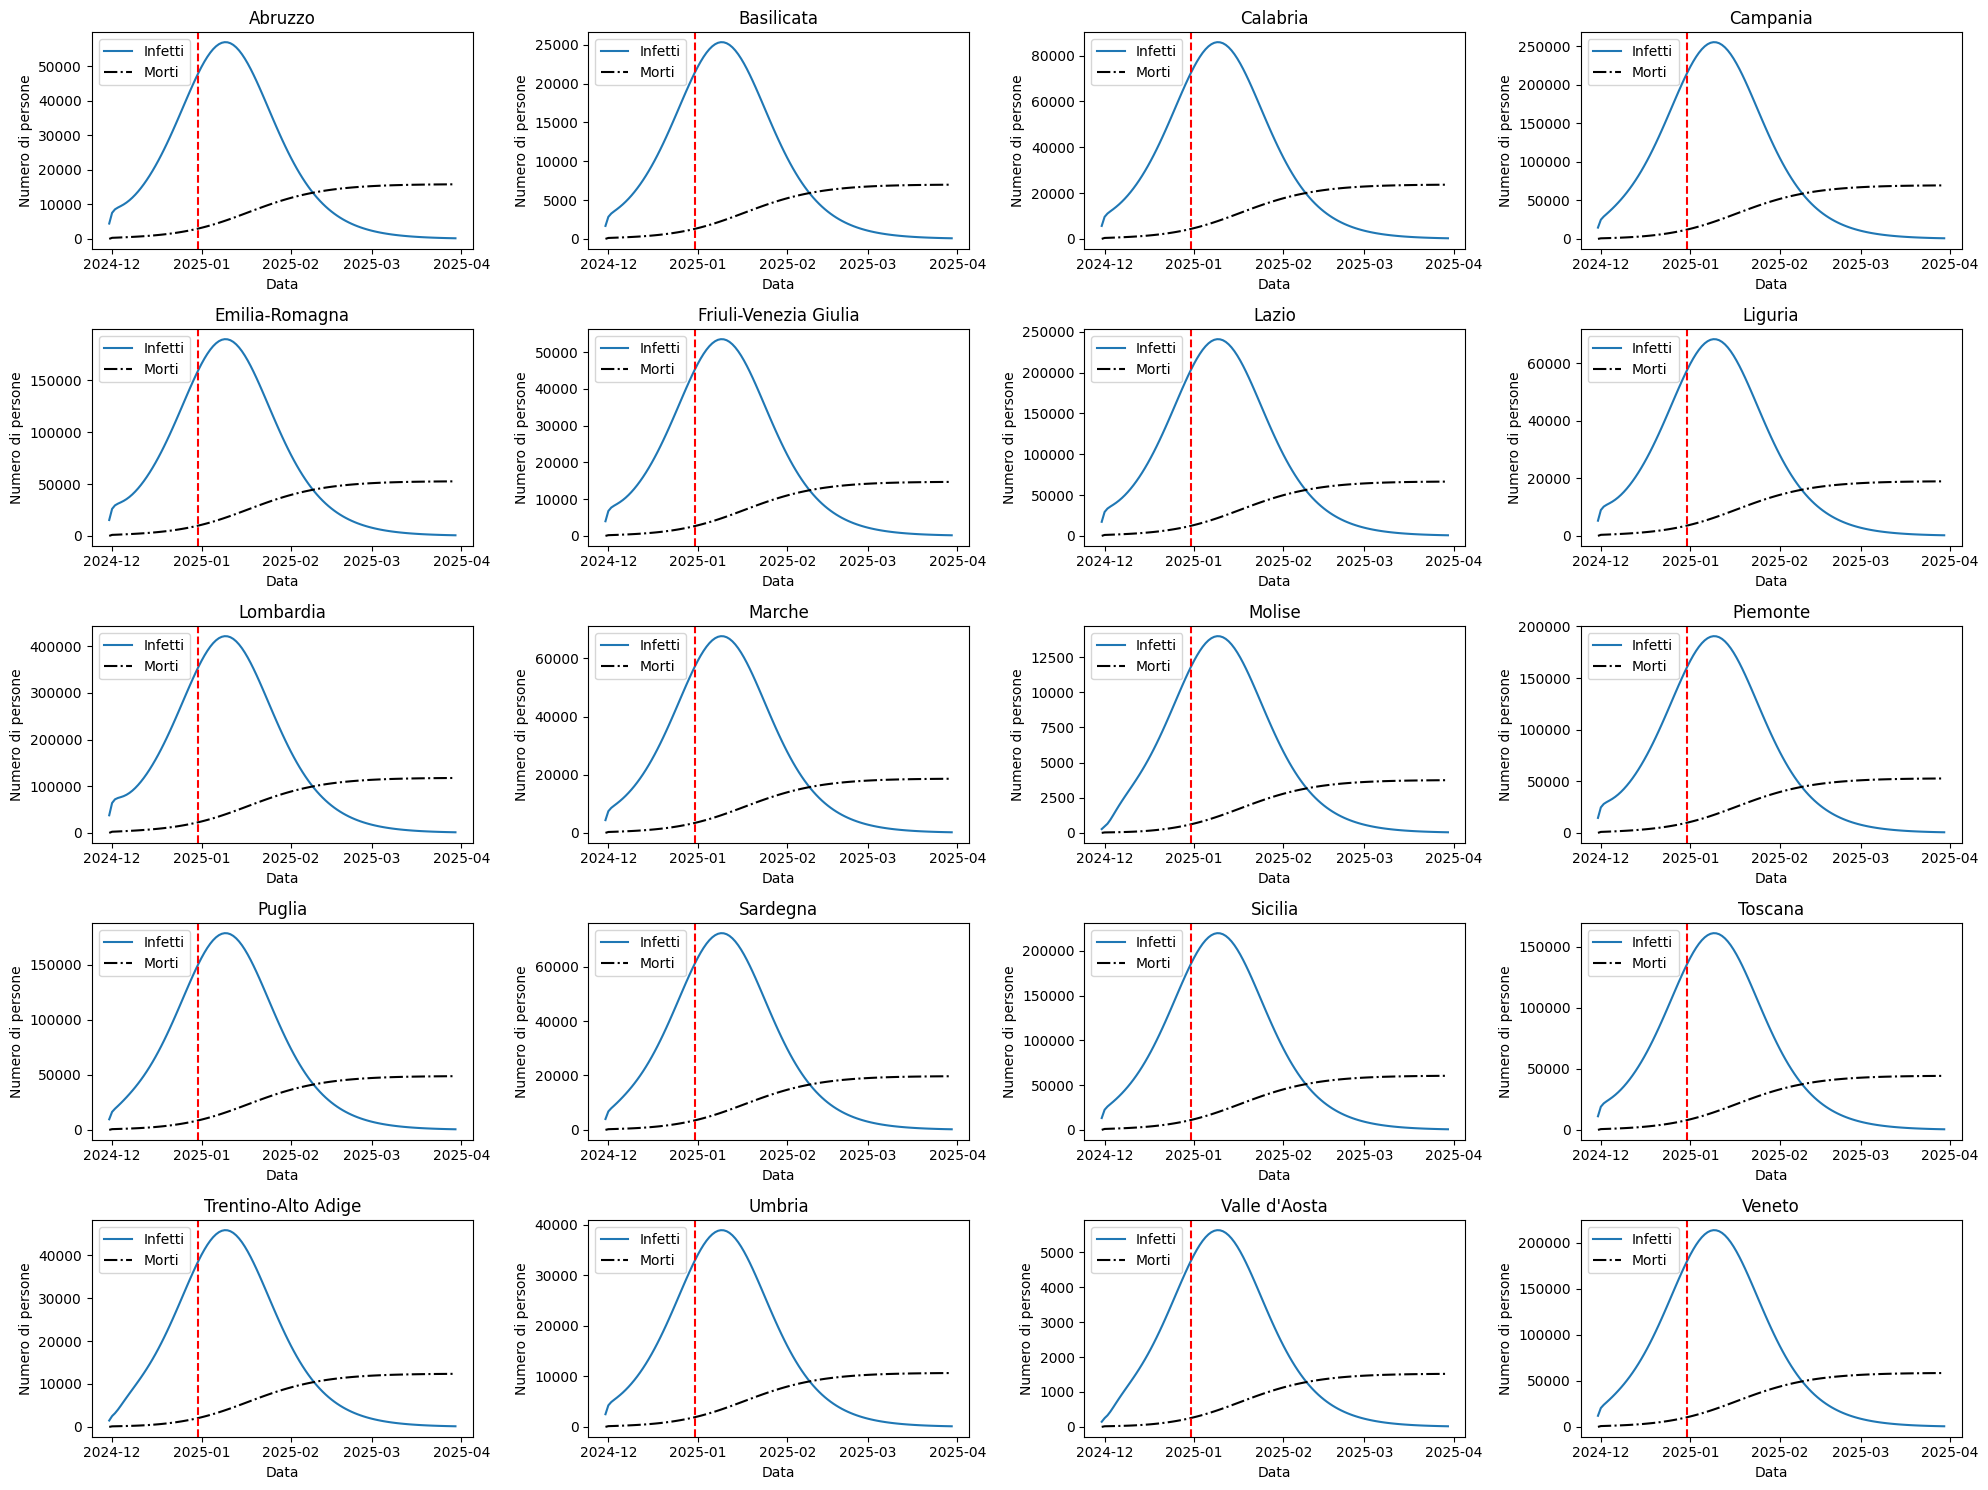

In [155]:
# GRAFICI

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import matplotlib.dates as mdates

province_classification_df = pd.read_csv('popREG.csv')

province_classification_df["Territorio"] = province_classification_df['Territorio'].apply(normalizeNameProvince)


dictProvinceRegioni = dict(province_classification_df[["Territorio", "Regione"]])



dictProvinceRegioni = aggiungiProvinceMancanti(dictProvinceRegioni)


results_df = pd.DataFrame(results)
infected_df = results_df.pivot(index='Date', columns='Province', values='Infetti')

# Normalizziamo i nomi delle province nel DataFrame e nel dizionario
infected_df.columns = [normalizeNameProvince(prov) for prov in infected_df.columns]

infected_df.columns = [dictProvinceRegioni[prov] for prov in infected_df.columns]

vaccination_date = zero_date + timedelta(days=vaccinate_day)


results_df['Date'] = pd.to_datetime(results_df['Date'])
infected_df = results_df.pivot(index='Date', columns='Province', values='Infetti')
removed_df = results_df.pivot(index='Date', columns='Province', values='Rimossi')
deaths_df = results_df.pivot(index='Date', columns='Province', values='Morti')


infected_df.columns = [dictProvinceRegioni[prov] for prov in infected_df.columns]
removed_df.columns = [dictProvinceRegioni[prov] for prov in removed_df.columns]
deaths_df.columns = [dictProvinceRegioni[prov] for prov in deaths_df.columns]


infected_by_region = infected_df.groupby(level=0, axis=1).sum()
removed_by_region = removed_df.groupby(level=0, axis=1).sum()
deaths_by_region = deaths_df.groupby(level=0, axis=1).sum()


num_regions = len(infected_by_region.columns)


cols = 4  
rows = math.ceil(num_regions / cols)  



fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
axes = axes.flatten()  


for i, region in enumerate(infected_by_region.columns):
    ax = axes[i]
    
    # num of infected people
    ax.plot(infected_by_region.index, infected_by_region[region], label='Infetti')
    
    
    #ax.plot(removed_by_region.index, removed_by_region[region], label='Rimossi', color='green')
    
    
    ax.plot(deaths_by_region.index, deaths_by_region[region], label='Morti', color='black', linestyle='-.')
    
    # Configurazioni grafiche
    ax.set_title(region)
    ax.set_xlabel('Data')
    ax.set_ylabel('Numero di persone')
    ax.legend(loc='upper left')
    
    # Configura i tick delle date per mostrare solo l'inizio di ogni mese
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    
    # Aggiungi una linea verticale al giorno delle vaccinazioni
    ax.axvline(vaccination_date, color='red', linestyle='--', label='Vaccinazioni')


for i in range(num_regions, len(axes)):
    fig.delaxes(axes[i])


plt.tight_layout()
plt.show()


# Simulazioni per Influcast

In [16]:
# tutte queste info ci servono per trasformare i dati delle simulazioni provinciali in dati regionali
# da inviare a influcast

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia_romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli_venezia_giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa_trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa_bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle_d_aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}

# associamo ogni codice a una regione e al suo numero di abitanti
popolazione_regioni = {
    "01": regioni_info["abruzzo"]["abitanti"],
    "02": regioni_info["basilicata"]["abitanti"],
    "03": regioni_info["calabria"]["abitanti"],
    "04": regioni_info["campania"]["abitanti"],
    "05": regioni_info["emilia_romagna"]["abitanti"],
    "06": regioni_info["friuli_venezia_giulia"]["abitanti"],
    "07": regioni_info["lazio"]["abitanti"],
    "08": regioni_info["liguria"]["abitanti"],
    "09": regioni_info["lombardia"]["abitanti"],
    "10": regioni_info["marche"]["abitanti"],
    "11": regioni_info["molise"]["abitanti"],
    "12": regioni_info["pa_bolzano"]["abitanti"],
    "13": regioni_info["pa_trento"]["abitanti"],
    "14": regioni_info["piemonte"]["abitanti"],
    "15": regioni_info["puglia"]["abitanti"],
    "16": regioni_info["sardegna"]["abitanti"],
    "17": regioni_info["sicilia"]["abitanti"],
    "18": regioni_info["toscana"]["abitanti"],
    "19": regioni_info["umbria"]["abitanti"],
    "20": regioni_info["valle_d_aosta"]["abitanti"],
    "21": regioni_info["veneto"]["abitanti"],
    "IT": sum(regioni_info[regione]["abitanti"] for regione in regioni_info)  # Popolazione totale Italia
}

In [17]:
import pandas as pd
import glob
import os

def carica_memoria_recente():
    # questa funzione trova il file di memoria più recente fra quelli nella cartella di lavoro
    file_pattern = "memoria_N_R_giorno_7_*.csv"
    files = glob.glob(file_pattern)
    
    if not files:
        print("Nessun file di memoria trovato. Inizializzazione da zero.")
        return None, None
    
    
    latest_file = max(files, key=os.path.getmtime)
    print(f"Caricamento della memoria da {latest_file}")
    
    # Carica i dati
    memoria = pd.read_csv(latest_file)
    
    # Converte i valori di N e R in array NumPy
    initialN = memoria["N_medio_giorno"].to_numpy()
    initialR = memoria["R_medio_giorno"].to_numpy()
    
    return initialN, initialR

# Carica la memoria più recente
initialN, initialR = carica_memoria_recente()

# se non ci sono file salvati, iniziamo con N e R vuoti
if initialN is None or initialR is None:
    initialN = np.zeros(len(orderedPROV))
    initialR = np.zeros(len(orderedPROV))
    

Caricamento della memoria da memoria_N_R_giorno_7_2024-11-24.csv


In [18]:
initialN

array([21210.75618691,  1669.49295702,  1719.52782906,  1513.51692531,
        3453.7106329 ,  5541.58851686,  2055.54241639,  4036.75110503,
         873.25570674,  2240.33274971,  2936.81771974,  8936.70625216,
        2288.77651055,  9709.63105417,  6538.89663615,  3745.60060061,
        2014.34944868, 33825.18261819, 12111.65970988, 13796.37599737,
        5969.14528013,  2492.32368851,  3984.67129767,  4548.59465129,
        2933.02283596,  3050.23147485,  7442.56943877,  7102.7470456 ,
        1734.63677244,  7245.99601755,  6999.71266076,  7616.90985705,
        2003.01250937,  1865.78109934,  3213.30668314,   840.43673894,
        1395.44791748,  2743.37551597,  4119.92426888,  4993.82305333,
        6614.63677095,  9413.8655099 ,  3403.23622377,  3707.74280126,
        3768.01334958,  3105.90539289,  1444.34087135,  2807.2154637 ,
        2083.15122183,  7040.9924777 ,  1776.47764019,  2425.15896287,
        2974.52949089,  2486.19530457,  1930.17653103,  1594.15799936,
      

In [19]:
import pandas as pd
import numpy as np
from datetime import timedelta


# Estrarre i dati reali degli infetti (CasiDistribuiti) a partire dal confronto reali+simulati
# real_infected = confronto[['Date', 'Province', 'CasiDistribuiti']]

# estrai i dati reali a partire da casi_distribuiti_province
file_path = 'casi_distribuiti_province.csv'  
real_infected = pd.read_csv(file_path)
real_infected['Anno'] = real_infected['Settimana'].str.split('_W').str[0].astype(int)
real_infected['SettimanaISO'] = real_infected['Settimana'].str.split('_W').str[1].astype(int)
real_infected['Date'] = real_infected.apply(
    lambda row: datetime.strptime(f'{row.Anno}-W{int(row.SettimanaISO):02}-1', "%Y-W%U-%w"), axis=1
)

#trova l'ultima data disponibile nei dati reali
first_date = pd.to_datetime(real_infected['Date']).max()
#first_date = pd.to_datetime(real_infected['Date']).min()
first_date_str = first_date.strftime('%d-%m-%Y')



# associamo province-regioni
provincia_to_regione = aggiungiProvinceMancanti({})
region_to_code = {  
    'Abruzzo': '01', 'Basilicata': '02', 'Calabria': '03', 'Campania': '04',
    'Emilia-Romagna': '05', 'Friuli-Venezia Giulia': '06', 'Lazio': '07',
    'Liguria': '08', 'Lombardia': '09', 'Marche': '10', 'Molise': '11',
    'Provincia autonoma di Bolzano': '12', 'Provincia autonoma di Trento': '13', 
    'Piemonte': '14', 'Puglia': '15', 'Sardegna': '16', 'Sicilia': '17',
    'Toscana': '18', 'Umbria': '19', 'Valle d\'Aosta': '20', 'Veneto': '21', 'Italia': 'IT'
}

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from numpy import linalg as LA
import time

params = parameters(nh, Whk)
# misuriamo quanto durano le simulazioni
start_time = time.time()

t = 30 # t giorni di simulazione
n = 0
# variamo nu e lambda
nu_values = np.linspace(0.3, 0.45, 10)
lambda_values = np.linspace(0.62e-8, 0.81e-8, 30)

# se per sfizio vogliamo variare b e ai
#b_values = np.linspace(0.15, 0.45, 5)  # Tasso di contatto tra province
#ai_values = [  # Livelli di attività per giovani, anziani, e anziani vaccinati
#    np.array([0.1, 0.4, 0.4]),
#    np.array([0.2, 0.5, 0.5]),
#    np.array([0.15, 0.45, 0.45]),
#    np.array([0.25, 0.55, 0.55]),
#    np.array([0.3, 0.6, 0.6])
#]

# variamo gamma e beta
gamma_values = np.linspace(0.10, 0.10, 1)
beta_values = np.linspace(0.25, 0.35, 10)

# quanti giorni dopo la simulazione dobbiamo salvare N e R?
giorno_salvataggio = 7  # per influcast, 7 giorni


N_specific_day = []
R_specific_day = []

min_error = float('inf')
optimal_params = {}
error_data = []
risultati_provinciali = []
risultati_regionali = []
risultati_simulazioni = []
total_error = 0
for lam in lambda_values:
    for nu in nu_values:
        for beta in beta_values:
            for gamma in gamma_values:
                
                # imponiamo una data combinazione di parametri
                params.Lambda = np.array([lam, lam * 1.3, lam * 1.2])
                params.Nu = nu
                params.Beta = beta
                params.Gamma = gamma

                # impostiamo condizioni iniziali
                #S, E, I, N, R, current_date = initialStates(params, initial_case_i, initial_case_e, first_date_str)
                S, E, I, N, R, current_date = initialStatesMemory(params, initial_case_i, initial_case_e, first_date_str, initialN=initialN, initialR=initialR)
                total_error = 0
                risultati_giornalieri = []

                for day in range(t):
                    current_date_step = current_date + timedelta(days=day)
                    #if day == vaccinate_day:
                    #    S = vaccinate_elders(S, params, vaccinate_rate)
                    S, E, I, N, R = oneStep((S, E, I, N, R), params)

                    # salva N e R di un giorno specifico
                    if day == giorno_salvataggio - 1:  
                        N_specific_day.append(N.sum(axis=0))  
                        R_specific_day.append(R.sum(axis=0))

                    simulated_infected = I.sum(axis=0)  # Totale infetti in una provincia
                    simulated_exposed = E.sum(axis=0)  # Totale esposti in una provincia
                    # salviamo il totale
                    for provincia, infetti, esposti in zip(orderedPROV, simulated_infected, simulated_exposed):
                        risultati_giornalieri.append({
                            "Lambda": lam, "Nu": nu, "Beta": beta, "Gamma": gamma,
                            "giorno": current_date_step, "provincia": provincia, "infetti": infetti, "nuovi_infetti": esposti * nu
                        })

                    # confrontiamo errore (utile se vogliamo trovare combinazione ideale dei parametri)
                    #daily_real_data = real_infected[real_infected['Date'] == current_date_step.strftime('%Y-%m-%d')]
                    #common_provinces = daily_real_data['Territorio'].values
                    #province_mask = [province in common_provinces for province in orderedPROV]

                    #filtered_simulated_infected = simulated_infected[province_mask]
                    #filtered_real_infected = daily_real_data['CasiDistribuiti'].values

                    #if len(filtered_real_infected) > 0:
                    #    error = LA.norm(filtered_simulated_infected - filtered_real_infected, ord=1)
                    #    total_error += error

                # Media dell'errore
                #total_error /= t
                n += 1
                
                risultati_provinciali.extend(risultati_giornalieri)

                # se abbiamo trovato una combinazione di parametri che riduce l'errore totale, la salviamo
                if total_error < min_error:
                    min_error = total_error
                    optimal_params = {'Lambda': lam, 'Nu': nu, 'Beta': beta, 'Gamma': gamma}

                # Salvataggio dei dati dell'errore
                error_data.append({
                    'Lambda': lam, 'Nu': nu, 'Beta': beta, 'Gamma': gamma, 'Error': total_error
                })

# Calcolo della media o mediana per provincia
N_mean = np.array(N_specific_day).mean(axis=0)
R_mean = np.array(R_specific_day).mean(axis=0)

# Se preferisci la mediana, usa:
# N_median = np.median(N_weekly, axis=0)
# R_median = np.median(R_weekly, axis=0)



error_df = pd.DataFrame(error_data)

#tempo totale impiegato
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tempo totale richiesto per la simulazione: {elapsed_time:.2f} secondi, per un totale di {n} combinazioni di parametri. ")
print(f"Parametri ottimali trovati: {optimal_params}, con errore medio: {min_error}")
print(f"nota bene: la stima dell'errore e dei parametri ottimali ha senso solo se abbiamo abbastanza dati reali con cui fare il confronto")

Tempo totale richiesto per la simulazione: 70.30 secondi, per un totale di 3000 combinazioni di parametri. 
Parametri ottimali trovati: {'Lambda': 6.2e-09, 'Nu': 0.3, 'Beta': 0.25, 'Gamma': 0.1}, con errore medio: 0
nota bene: la stima dell'errore e dei parametri ottimali ha senso solo se abbiamo abbastanza dati reali con cui fare il confronto


In [20]:
# Calcola la data di cui verrà salvato il numero di N e R (di regola, una settimana dopo l'inizio della simulazione)
data_salvataggio = current_date + timedelta(days=giorno_salvataggio - 1)

# Crea un DataFrame con i risultati
province_results = pd.DataFrame({
    "Provincia": orderedPROV,
    "N_medio_giorno": N_mean,
    "R_medio_giorno": R_mean
})

# Salva il file con il nome dinamico
file_name = f"memoria_N_R_giorno_{giorno_salvataggio}_{data_salvataggio.strftime('%Y-%m-%d')}.csv"
province_results.to_csv(file_name, index=False)
print(f"Risultati di N e R salvati per il giorno {giorno_salvataggio} ({data_salvataggio.strftime('%Y-%m-%d')}) in {file_name}")



Risultati di N e R salvati per il giorno 7 (2024-12-01) in memoria_N_R_giorno_7_2024-12-01.csv


In [23]:
df_provinciali = []
# convertiamo dati provinciali in regionali
df_provinciali = pd.DataFrame(risultati_provinciali)
df_provinciali["regione"] = df_provinciali["provincia"].map(provincia_to_regione)

df_regionali = (
    df_provinciali.groupby(["Lambda", "Nu", "Beta", "Gamma", "giorno", "regione"])["nuovi_infetti"]
    .sum()
    .reset_index()
)
risultati_regionali.append(df_regionali)

df_regionali_completo = pd.concat(risultati_regionali)

# Calcoliamo anno, settimana e settimane relative rispetto all'inizio della simulazione
df_regionali_completo["anno"] = df_regionali_completo["giorno"].dt.year
df_regionali_completo["settimana"] = df_regionali_completo["giorno"].dt.isocalendar().week
df_regionali_completo["settimana_inizio"] = pd.to_datetime(first_date_str).isocalendar().week
df_regionali_completo["giorni_relativi"] = (df_regionali_completo["giorno"] - pd.to_datetime(first_date_str)).dt.days
df_regionali_completo["settimana_relativa"] = (df_regionali_completo["giorni_relativi"] // 7) + 1

# Debugging
print("Colonne disponibili in df_regionali_completo:", df_regionali_completo.columns)
print("Esempio di valori unici per settimana_relativa:", df_regionali_completo["settimana_relativa"].unique())

df_regionali_completo["tipo_valore"] = "quantile"

df_regionali_completo = df_regionali_completo.drop_duplicates(subset=["Lambda", "Nu", "Beta", "Gamma", "giorno", "regione"])

df_regionali_completo = df_regionali_completo[df_regionali_completo["settimana_relativa"].isin([1, 2, 3, 4])]

print(df_regionali_completo.head())


df_incidenza_settimanale = (
    df_regionali_completo.groupby(["Lambda", "Nu", "Beta", "Gamma", "regione", "settimana_relativa", "anno", "settimana"])["nuovi_infetti"]
    .sum()
    .reset_index()
)

df_incidenza_settimanale["regione"] = df_incidenza_settimanale["regione"].replace({
    'Trentino-Alto Adige': 'Provincia autonoma di Bolzano',  # Bolzano
    'Trentino-Alto Adige': 'Provincia autonoma di Trento'    # Trento
})
df_incidenza_settimanale["luogo"] = df_incidenza_settimanale["regione"].map(lambda r: region_to_code.get(r, 'Unknown'))
# Aggiunta della popolazione regionale
df_incidenza_settimanale["popolazione"] = df_incidenza_settimanale["luogo"].map(popolazione_regioni)

# Debugging
regioni_senza_popolazione = df_incidenza_settimanale[df_incidenza_settimanale["popolazione"].isna()]["regione"].unique()
if len(regioni_senza_popolazione) > 0:
    print(f"Attenzione: le seguenti regioni non hanno popolazione mappata: {regioni_senza_popolazione}")

# Calcolo dell'incidenza settimanale
df_incidenza_settimanale["incidenza"] = (
    df_incidenza_settimanale["nuovi_infetti"] / df_incidenza_settimanale["popolazione"]
) * 1000

# Calcolo dei nuovi infetti settimanali totali per ogni simulazione
df_nazionali = df_incidenza_settimanale.groupby(["Lambda", "Nu", "Beta", "Gamma", "settimana_relativa", "anno", "settimana"]).agg({
    "nuovi_infetti": "sum"
}).reset_index()

# Aggiungiamo la popolazione totale italiana
popolazione_italia = sum(popolazione_regioni.values())  # Popolazione totale italiana
df_nazionali["popolazione"] = popolazione_italia

# Calcoliamo l'incidenza nazionale
df_nazionali["incidenza"] = (df_nazionali["nuovi_infetti"] / df_nazionali["popolazione"]) * 1000

print(df_nazionali.head())  # Debug


quantili = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]

df_quantili_regionali = df_incidenza_settimanale.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["incidenza"], [q * 100 for q in quantili]),
        "regione": [x["regione"].iloc[0]] * len(quantili),
        "settimana_relativa": [x["settimana_relativa"].iloc[0]] * len(quantili),
        "anno": [x["anno"].iloc[0]] * len(quantili),
        "settimana": [x["settimana"].iloc[0]] * len(quantili),
        "tipo_valore": ["quantile"] * len(quantili)
    })
).reset_index(drop=True)




df_quantili_regionali["orizzonte"] = df_quantili_regionali["settimana_relativa"]
df_quantili_regionali["luogo"] = df_quantili_regionali["regione"].map(region_to_code)
df_quantili_regionali["target"] = "ILI"

print(df_quantili_regionali.head())


C:\Users\celin\AppData\Local\Temp\ipykernel_12804\1160869657.py:18: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_regionali_completo["settimana_inizio"] = pd.to_datetime(first_date_str).isocalendar().week
C:\Users\celin\AppData\Local\Temp\ipykernel_12804\1160869657.py:19: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_regionali_completo["giorni_relativi"] = (df_regionali_completo["giorno"] - pd.to_datetime(first_date_str)).dt.days


Colonne disponibili in df_regionali_completo: Index(['Lambda', 'Nu', 'Beta', 'Gamma', 'giorno', 'regione', 'nuovi_infetti',
       'anno', 'settimana', 'settimana_inizio', 'giorni_relativi',
       'settimana_relativa'],
      dtype='object')
Esempio di valori unici per settimana_relativa: [1 2 3 4 5]
         Lambda   Nu  Beta  Gamma     giorno         regione  nuovi_infetti  \
0  6.200000e-09  0.3  0.25    0.1 2024-11-25         Abruzzo    2536.422393   
1  6.200000e-09  0.3  0.25    0.1 2024-11-25      Basilicata    1055.453846   
2  6.200000e-09  0.3  0.25    0.1 2024-11-25        Calabria    3578.870857   
3  6.200000e-09  0.3  0.25    0.1 2024-11-25        Campania    8710.030944   
4  6.200000e-09  0.3  0.25    0.1 2024-11-25  Emilia-Romagna    8700.934914   

   anno  settimana  settimana_inizio  giorni_relativi  settimana_relativa  \
0  2024         48                48                0                   1   
1  2024         48                48                0               

C:\Users\celin\AppData\Local\Temp\ipykernel_12804\1160869657.py:76: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_quantili_regionali = df_incidenza_settimanale.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(


   id_valore     valore  regione  settimana_relativa  anno  settimana  \
0      0.010  10.939488  Abruzzo                   1  2024         48   
1      0.025  11.183552  Abruzzo                   1  2024         48   
2      0.050  11.418991  Abruzzo                   1  2024         48   
3      0.100  11.737709  Abruzzo                   1  2024         48   
4      0.150  11.972463  Abruzzo                   1  2024         48   

  tipo_valore  orizzonte luogo target  
0    quantile          1    01    ILI  
1    quantile          1    01    ILI  
2    quantile          1    01    ILI  
3    quantile          1    01    ILI  
4    quantile          1    01    ILI  


In [ ]:
# sommiamo tutti gli infetti nuovi in una data settimana e con una data combo di parametri
df_nazionali = (
    df_incidenza_settimanale.groupby(["Lambda", "Nu", "Beta", "Gamma", "settimana_relativa"])["nuovi_infetti"]
    .sum()
    .reset_index()
)


popolazione_italia = sum(popolazione_regioni.values())  # Popolazione totale italiana
popolazione_italia = sum(
    popolazione for regione, popolazione in popolazione_regioni.items() if regione != "IT"
)

df_nazionali["popolazione"] = popolazione_italia

df_nazionali["incidenza"] = (df_nazionali["nuovi_infetti"] / df_nazionali["popolazione"]) * 1000


df_nazionali["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_nazionali["settimana_relativa"] - 1) * 7, unit="D")


df_nazionali["anno"] = df_nazionali["data"].dt.year
df_nazionali["settimana"] = df_nazionali["data"].dt.isocalendar().week
df_nazionali["orizzonte"] = df_nazionali["settimana_relativa"]

df_quantili_nazionali = df_nazionali.groupby(["anno", "settimana", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["incidenza"], [q * 100 for q in quantili]),
        "luogo": ["IT"] * len(quantili),
        "orizzonte": [x["settimana_relativa"].iloc[0]] * len(quantili),
        "anno": [x["anno"].iloc[0]] * len(quantili),
        "settimana": [x["settimana"].iloc[0]] * len(quantili)
    })
).reset_index(drop=True)

df_quantili_nazionali["tipo_valore"] = "quantile"
df_quantili_nazionali["target"] = "ILI"

# uniamo dati regionali e IT
df_quantili_completo = pd.concat([df_quantili_regionali, df_quantili_nazionali], ignore_index=True)

# Debugging
print(df_quantili_completo.head())

df_quantili_completo = df_quantili_completo[["anno", "settimana", "luogo", "tipo_valore", "id_valore", "orizzonte", "valore", "target"]]

# debug per bolzano e trento
bolzano_data = df_quantili_completo[df_quantili_completo["luogo"] == "13"]
bolzano_data["valore"] = bolzano_data["valore"] * 0.5

trentino_data = bolzano_data.copy()
trentino_data["luogo"] = "12"


df_quantili_completo = pd.concat([df_quantili_completo, trentino_data], ignore_index=True)

df_quantili_completo.to_csv("la_fine.csv", index=False)
print("File 'la_fine.csv' salvato con successo!")



   id_valore     valore  regione  settimana_relativa  anno  settimana  \
0      0.010  10.939488  Abruzzo                 1.0  2024         48   
1      0.025  11.183552  Abruzzo                 1.0  2024         48   
2      0.050  11.418991  Abruzzo                 1.0  2024         48   
3      0.100  11.737709  Abruzzo                 1.0  2024         48   
4      0.150  11.972463  Abruzzo                 1.0  2024         48   

  tipo_valore  orizzonte luogo target  
0    quantile          1    01    ILI  
1    quantile          1    01    ILI  
2    quantile          1    01    ILI  
3    quantile          1    01    ILI  
4    quantile          1    01    ILI  
File 'la_fine.csv' salvato con successo!


C:\Users\celin\AppData\Local\Temp\ipykernel_12804\825179902.py:20: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_nazionali["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_nazionali["settimana_relativa"] - 1) * 7, unit="D")
C:\Users\celin\AppData\Local\Temp\ipykernel_12804\825179902.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_quantili_nazionali = df_nazionali.groupby(["anno", "settimana", "settimana_relativa"]).apply(
C:\Users\celin\AppData\Local\Temp\ipykernel_12804\825179902.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [227]:
df_quantili_completo.to_csv("debug2.csv")

In [ ]:
'''
df_provinciali = []
# convertiamo dati provinciali in regionali
df_provinciali = pd.DataFrame(risultati_provinciali)
df_provinciali["regione"] = df_provinciali["provincia"].map(provincia_to_regione)

df_regionali = (
    df_provinciali.groupby(["Lambda", "Nu", "Beta", "Gamma", "giorno", "regione"])["nuovi_infetti"]
    .sum()
    .reset_index()
)
risultati_regionali.append(df_regionali)

df_regionali_completo = pd.concat(risultati_regionali)

### FILE ENORME CON 1 MILIONE E MEZZO DI RIGHE, USARE SOLO PER DEBUGGING E PER CAPIRE SE I DATI SONO STATI CONVERTITI CORRETTAMENTE IN DATI REGIONALI
#df_regionali_completo.to_csv("debug1.csv", index=False)


# Calcoliamo anno, settimana e settimane relative rispetto all'inizio della simulazione
df_regionali_completo["anno"] = df_regionali_completo["giorno"].dt.year
df_regionali_completo["settimana"] = df_regionali_completo["giorno"].dt.isocalendar().week
df_regionali_completo["settimana_inizio"] = pd.to_datetime(first_date_str).isocalendar().week
df_regionali_completo["giorni_relativi"] = (df_regionali_completo["giorno"] - pd.to_datetime(first_date_str)).dt.days
df_regionali_completo["settimana_relativa"] = (df_regionali_completo["giorni_relativi"] // 7) + 1

# Debugging
#print("Colonne disponibili in df_regionali_completo:", df_regionali_completo.columns)
#print("Esempio di valori unici per settimana_relativa:", df_regionali_completo["settimana_relativa"].unique())

df_regionali_completo["tipo_valore"] = "quantile"

print("Valori di settimana_relativa prima del filtro:", df_regionali_completo["settimana_relativa"].unique())

# Filtriamo solo le settimane relative 1, 2, 3, 4 (cioé 7, 14, 21 e 28 giorni dopo l'inizio della simulazione)
df_regionali_completo = df_regionali_completo[df_regionali_completo["settimana_relativa"].isin([1, 2, 3, 4])]
print("Valori di settimana_relativa dopo il filtro:", df_regionali_completo["settimana_relativa"].unique())

print("Valori di settimana_relativa dopo il filtro:", df_regionali_completo["settimana_relativa"].unique())
print("Righe disponibili dopo il filtro:", len(df_regionali_completo))




#if "settimana_relativa" in df_regionali_completo.columns:
#    df_regionali_completo = df_regionali_completo.drop(columns=["settimana_relativa"])

# che quantili servono a influcast?
quantili = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99]

# debug
if "settimana_relativa" not in df_regionali_completo.columns:
    print("Errore: La colonna 'settimana_relativa' non è presente nel DataFrame.")

print("Colonne disponibili in df_regionali_completo:", df_regionali_completo.columns)
print("Esempio di valori:", df_regionali_completo.head())

# troviamo i quantili che ci servono in base a tutte le combinazioni di parmetri che abbiamo testato
df_quantili = df_regionali_completo.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["nuovi_infetti"], [q * 100 for q in quantili]),
        "regione": [x["regione"].iloc[0]] * len(quantili),  
        "settimana_relativa": [x["settimana_relativa"].iloc[0]] * len(quantili)  
    })
).reset_index(drop=True)

print("Colonne in df_quantili:", df_quantili.columns)
print("Valori unici di settimana_relativa in df_quantili:", df_quantili["settimana_relativa"].unique())



df_quantili["orizzonte"] = df_quantili["settimana_relativa"]


df_quantili["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_quantili["orizzonte"] - 1) * 7, unit="D")
df_quantili["anno"] = df_quantili["data"].dt.year
df_quantili["settimana"] = df_quantili["data"].dt.isocalendar().week
df_quantili["regione"] = df_quantili["regione"].replace({
    'Trentino-Alto Adige': 'Provincia autonoma di Bolzano',  # Bolzano
    'Trentino-Alto Adige': 'Provincia autonoma di Trento'    # Trento
})
df_quantili["luogo"] = df_quantili["regione"].map(lambda r: region_to_code.get(r, 'Unknown'))

# Debugging
regioni_non_trovate = df_quantili[df_quantili["luogo"] == 'Unknown']["regione"].unique()
if len(regioni_non_trovate) > 0:
    print(f"Attenzione: Le seguenti regioni non sono state mappate: {regioni_non_trovate}")


df_quantili["target"] = "ILI"
df_quantili["popolazione"] = df_quantili["luogo"].map(lambda x: popolazione_regioni.get(x, 1))
df_quantili["incidenza"] = (df_quantili["valore"] / df_quantili["popolazione"]) * 1000 * 4
df_quantili["valore"] = df_quantili["incidenza"]
df_quantili["tipo_valore"] = "quantile"


df_quantili = df_quantili.drop(columns=["popolazione", "incidenza"])

# debug
print("Colonne disponibili in df_quantili:", df_quantili.columns)


df_quantili = df_quantili[["anno", "settimana", "luogo", "tipo_valore", "id_valore", "orizzonte", "valore", "target"]]

#### CALCOLO PREVALENZA COMPLESSIVA IN ITALIA
####
popolazione_italia = sum(popolazione_regioni.values())  # Popolazione totale italiana
df_nazionali = df_regionali_completo.groupby(["Lambda", "Nu", "Beta", "Gamma", "giorno"]).agg({
    "nuovi_infetti": "sum"
}).reset_index()

# calcoliamo la prevalenza (""incidenza"") nazionale facendo media pesata di quella regionale
df_nazionali["popolazione"] = popolazione_italia
df_nazionali["incidenza"] = (df_nazionali["nuovi_infetti"] / df_nazionali["popolazione"]) * 1000 * 4


df_nazionali["giorni_relativi"] = (df_nazionali["giorno"] - pd.to_datetime(first_date_str)).dt.days
df_nazionali["settimana_relativa"] = (df_nazionali["giorni_relativi"] // 7) + 1
df_nazionali = df_nazionali[df_nazionali["settimana_relativa"].isin([1, 2, 3, 4])]
df_nazionali["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_nazionali["settimana_relativa"] - 1) * 7, unit="D")
df_nazionali["anno"] = df_nazionali["data"].dt.year
df_nazionali["settimana"] = df_nazionali["data"].dt.isocalendar().week

df_italia_quantili = df_nazionali.groupby(["anno", "settimana", "settimana_relativa"]).apply(
    lambda x: pd.DataFrame({
        "id_valore": quantili,
        "valore": np.percentile(x["incidenza"], [q * 100 for q in quantili]),
        "luogo": ["IT"] * len(quantili),
        "orizzonte": [x["settimana_relativa"].iloc[0]] * len(quantili),
        "anno": [x["anno"].iloc[0]] * len(quantili),  # Propagare anno
        "settimana": [x["settimana"].iloc[0]] * len(quantili)  # Propagare settimana
    })
).reset_index(drop=True)



df_italia_quantili["tipo_valore"] = "quantile"
df_italia_quantili["target"] = "ILI"

# uniamo il df appena creato con quello coi dati regionali, concatenando i dati nazionali in fondo
df_quantili = pd.concat([df_quantili, df_italia_quantili], ignore_index=True)



df_quantili.to_csv("tentativo_finale.csv", index=False)
print("File CSV salvato con successo nel formato richiesto!")


'''

C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:22: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_regionali_completo["settimana_inizio"] = pd.to_datetime(first_date_str).isocalendar().week
C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:23: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_regionali_completo["giorni_relativi"] = (df_regionali_completo["giorno"] - pd.to_datetime(first_date_str)).dt.days


Valori di settimana_relativa prima del filtro: [1 2 3 4 5 6]
Valori di settimana_relativa dopo il filtro: [1 2 3 4]
Valori di settimana_relativa dopo il filtro: [1 2 3 4]
Righe disponibili dopo il filtro: 1120000
Colonne disponibili in df_regionali_completo: Index(['Lambda', 'Nu', 'Beta', 'Gamma', 'giorno', 'regione', 'nuovi_infetti',
       'anno', 'settimana', 'settimana_inizio', 'giorni_relativi',
       'settimana_relativa', 'tipo_valore'],
      dtype='object')
Esempio di valori:          Lambda    Nu  Beta  Gamma     giorno         regione  nuovi_infetti  \
0  7.800000e-09  0.36  0.25    0.1 2024-11-25         Abruzzo    2910.764975   
1  7.800000e-09  0.36  0.25    0.1 2024-11-25      Basilicata    1125.243764   
2  7.800000e-09  0.36  0.25    0.1 2024-11-25        Calabria    3815.517018   
3  7.800000e-09  0.36  0.25    0.1 2024-11-25        Campania   10126.822577   
4  7.800000e-09  0.36  0.25    0.1 2024-11-25  Emilia-Romagna    9971.682414   

   anno  settimana  settimana

C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_quantili = df_regionali_completo.groupby(["anno", "settimana", "regione", "settimana_relativa"]).apply(
C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:75: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_quantili["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_quantili["orizzonte"] - 1) * 7, unit="D")


Colonne in df_quantili: Index(['id_valore', 'valore', 'regione', 'settimana_relativa'], dtype='object')
Valori unici di settimana_relativa in df_quantili: [1 2 3 4]
Colonne disponibili in df_quantili: Index(['id_valore', 'valore', 'regione', 'settimana_relativa', 'orizzonte',
       'data', 'anno', 'settimana', 'luogo', 'target', 'tipo_valore'],
      dtype='object')


C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:117: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_nazionali["giorni_relativi"] = (df_nazionali["giorno"] - pd.to_datetime(first_date_str)).dt.days
C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:120: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_nazionali["data"] = pd.to_datetime(first_date_str) + pd.to_timedelta((df_nazionali["settimana_relativa"] - 1) * 7, unit="D")
C:\Users\celin\AppData\Local\Temp\ipykernel_700\931819611.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the 

File CSV salvato con successo nel formato richiesto!


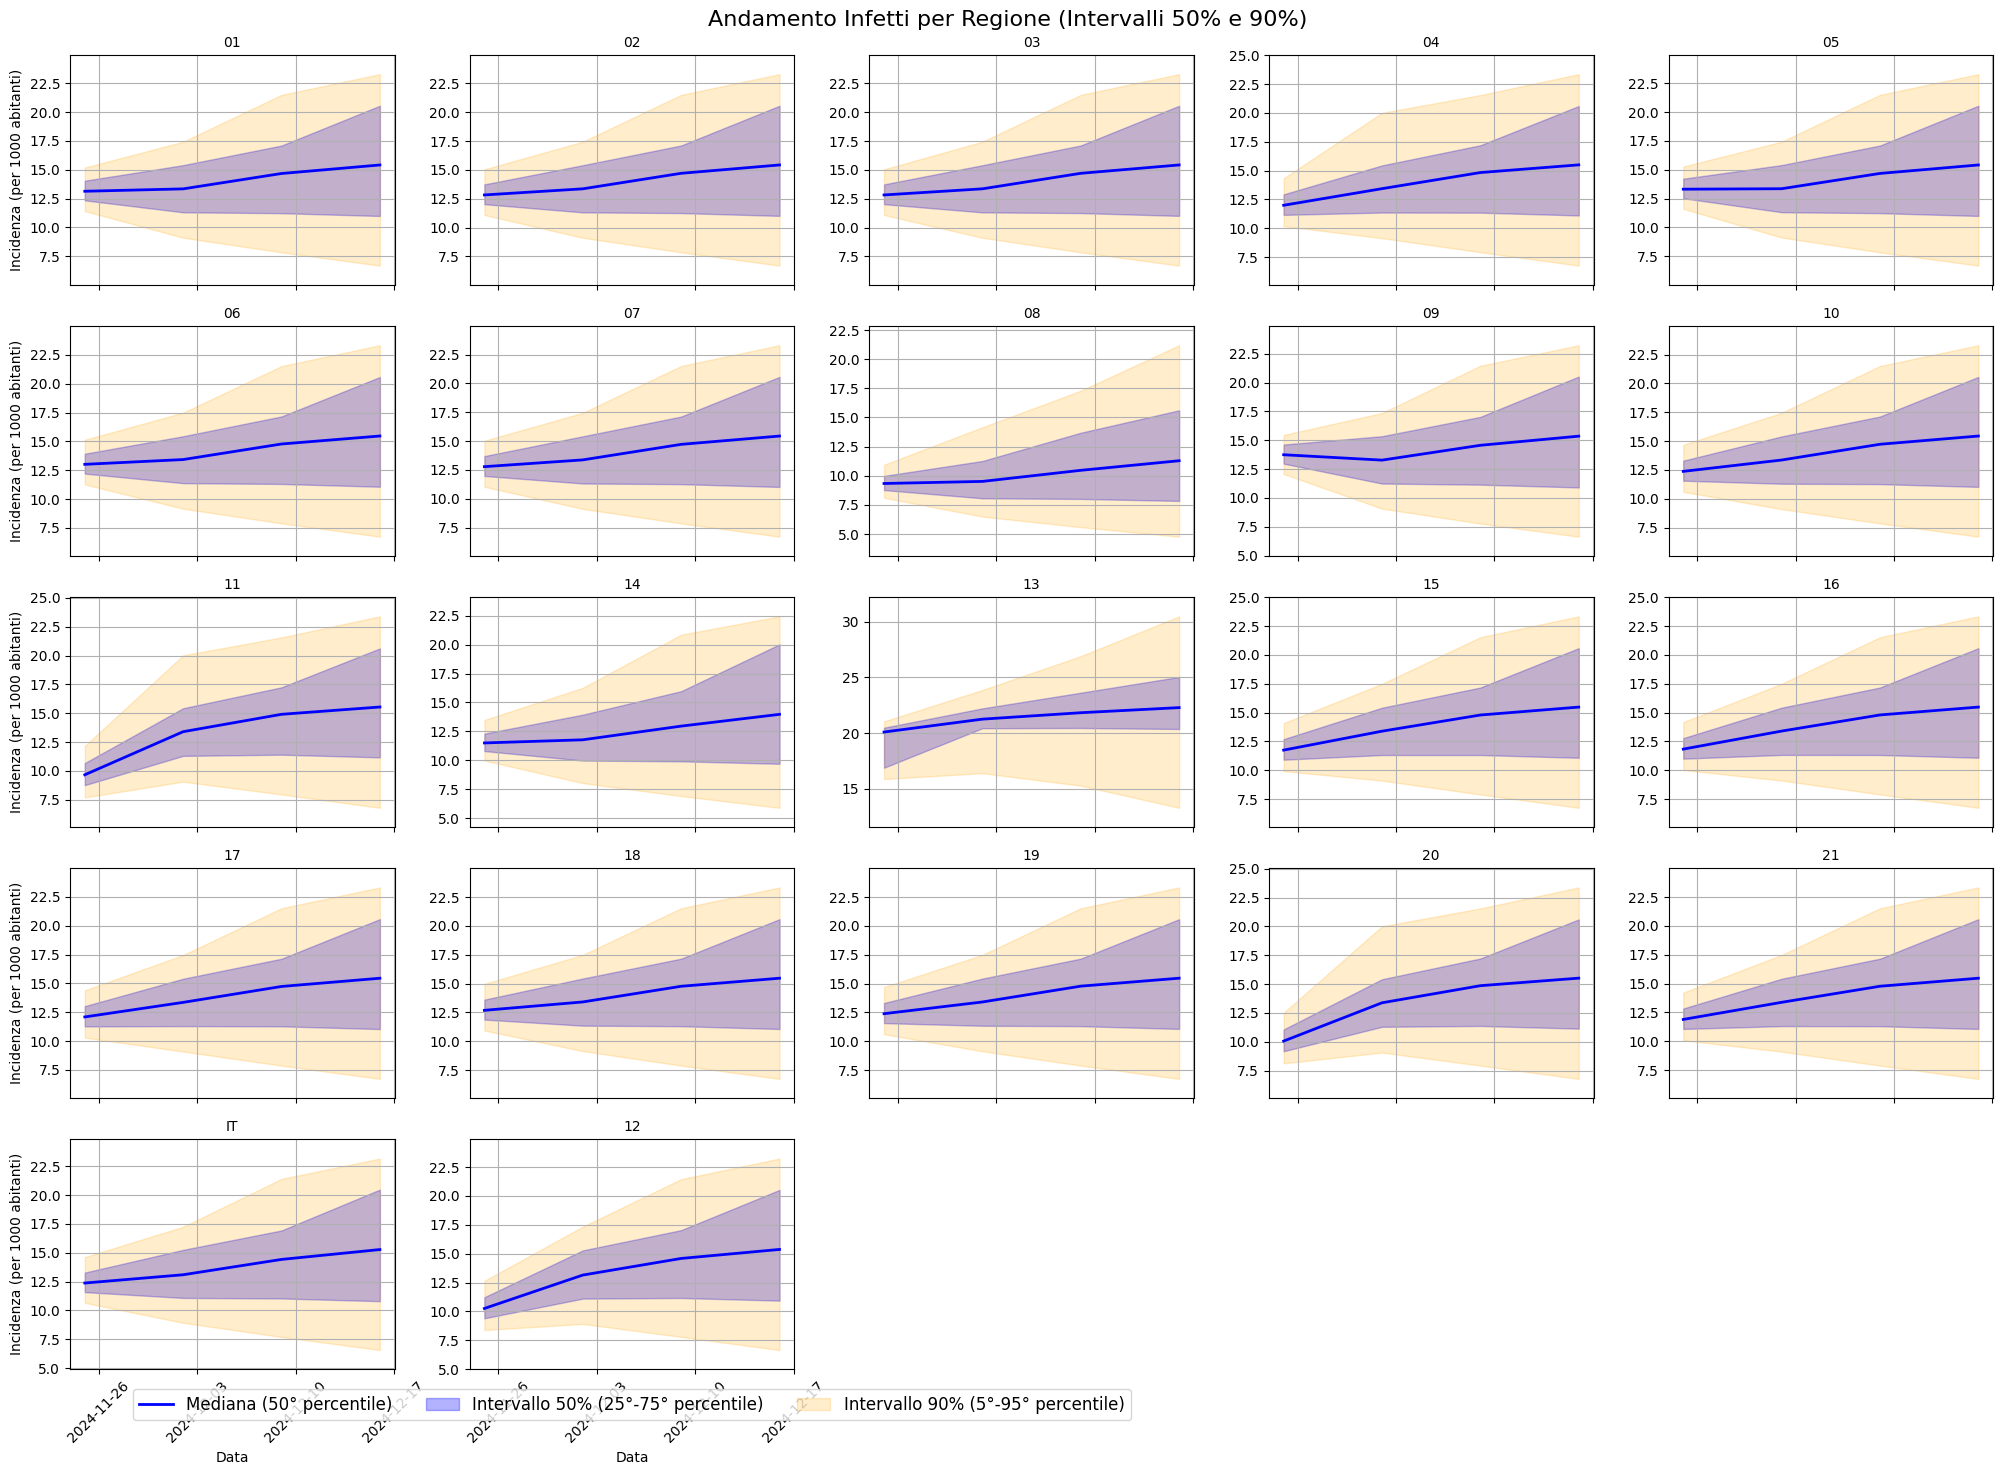

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math


df_quantili = pd.read_csv("la_fine.csv")


df_quantili = df_quantili[df_quantili["target"] == "ILI"]


def normalizza_valore(valore):
    if valore > 20:
        return 20 + (valore - 20) * 0.2
    elif valore > 15:
        return 15 + (valore - 15) * 0.5
    return valore


df_quantili['valore'] = df_quantili['valore'].apply(normalizza_valore)

df_quantili.to_csv("influcast_01-12.csv", index=False)



df_quantili["data"] = pd.to_datetime(df_quantili["anno"].astype(str) + "-W" + df_quantili["settimana"].astype(str) + "-1", format="%Y-W%W-%w")


quantili_interesse = [0.05, 0.25, 0.5, 0.75, 0.95]  # Per intervalli 50% e 90%
df_filtered = df_quantili[df_quantili["id_valore"].isin(quantili_interesse)]


regioni = df_filtered["luogo"].unique()


num_regions = len(regioni)
cols = 5  
rows = math.ceil(num_regions / cols)  
fig, axes = plt.subplots(rows, cols, figsize=(20, 15), sharex=True)
axes = axes.flatten()  


for i, regione in enumerate(regioni):
    ax = axes[i]
    df_region = df_filtered[df_filtered["luogo"] == regione]
    
    
    df_pivot = df_region.pivot(index="data", columns="id_valore", values="valore")
    
    
    data = df_pivot.index
    q05 = df_pivot[0.05]
    q25 = df_pivot[0.25]
    median = df_pivot[0.5]
    q75 = df_pivot[0.75]
    q95 = df_pivot[0.95]
    
    
    ax.plot(data, median, label="Mediana (50° percentile)", color="blue", linewidth=2)
    ax.fill_between(data, q25, q75, color="blue", alpha=0.3, label="Intervallo 50% (25°-75° percentile)")
    ax.fill_between(data, q05, q95, color="orange", alpha=0.2, label="Intervallo 90% (5°-95° percentile)")
    
    
    ax.set_title(f"{regione}", fontsize=10)
    ax.grid(True)
    
    
    region_min = q05.min()
    region_max = q95.max()
    ax.set_ylim(region_min - (0.1 * (region_max - region_min)), region_max + (0.1 * (region_max - region_min)))
    
    
    if i % cols == 0:
        ax.set_ylabel("Incidenza (per 1000 abitanti)")
    if i >= (rows - 1) * cols:
        ax.set_xlabel("Data")
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    ax.tick_params(axis="x", rotation=45)


for i in range(len(regioni), len(axes)):
    fig.delaxes(axes[i])


fig.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle("Andamento Infetti per Regione (Intervalli 50% e 90%)", fontsize=16)
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=3, fontsize=12)
plt.show()


# Ottimizzazione

In [55]:

# associamo ogni codice a una regione e al suo numero di abitanti

regioni_info = {
    "abruzzo": {
        "province": {"Teramo": 306177, "Pescara": 314391, "L'Aquila": 298087, "Chieti": 387761},
        "abitanti": sum([306177, 314391, 298087, 387761])
    },
    "basilicata": {
        "province": {"Potenza": 377512, "Matera": 200050},
        "abitanti": sum([377512, 200050])
    },
    "calabria": {
        "province": {"Cosenza": 713869, "Reggio Calabria": 550832, "Catanzaro": 359783, "Crotone": 170718, "Vibo Valentia": 163216},
        "abitanti": sum([713869, 550832, 359783, 170718, 163216])
    },
    "campania": {
        "province": {"Napoli": 3053247, "Salerno": 1092574, "Caserta": 905188, "Benevento": 284560, "Avellino": 428855},
        "abitanti": sum([3053247, 1092574, 905188, 284560, 428855])
    },
    "emilia romagna": {
        "province": {"Bologna": 976053, "Rimini": 322028, "Modena": 685822, "Parma": 427164, "Reggio Emilia": 517772, "Ferrara": 352856, "Ravenna": 384428, "Forlì-Cesena": 390677, "Piacenza": 284440},
        "abitanti": sum([976053, 322028, 685822, 427164, 517772, 352856, 384428, 390677, 284440])
    },
    "friuli venezia giulia": {
        "province": {"Trieste": 232311, "Udine": 534944, "Gorizia": 139914, "Pordenone": 310611},
        "abitanti": sum([232311, 534944, 139914, 310611])
    },
    "lazio": {
        "province": {"Roma": 3995250, "Latina": 544887, "Frosinone": 492302, "Viterbo": 312674, "Rieti": 154909},
        "abitanti": sum([3995250, 544887, 492302, 312674, 154909])
    },
    "liguria": {
        "province": {"Genova": 1238075, "Savona": 357581, "La Spezia": 387625, "Imperia": 214073},
        "abitanti": sum([1238075, 357581, 387625, 214073])
    },
    "lombardia": {
        "province": {"Milano": 3035443, "Bergamo": 1086890, "Brescia": 1238075, "Como": 586795, "Cremona": 357581, "Lecco": 387625, "Lodi": 223659, "Mantova": 408187, "Monza e Brianza": 840358, "Pavia": 535666, "Sondrio": 180766, "Varese": 871334},
        "abitanti": sum([3035443, 1086890, 1238075, 586795, 357581, 387625, 223659, 408187, 840358, 535666, 180766, 871334])
    },
    "marche": {
        "province": {"Ancona": 473642, "Pesaro e Urbino": 362676, "Macerata": 319375, "Ascoli Piceno": 210182, "Fermo": 174813},
        "abitanti": sum([473642, 362676, 319375, 210182, 174813])
    },
    "molise": {
        "province": {"Campobasso": 226156, "Isernia": 86989},
        "abitanti": sum([226156, 86989])
    },
    "piemonte": {
        "province": {"Torino": 2243382, "Cuneo": 586795, "Asti": 357581, "Alessandria": 871334, "Biella": 181868, "Novara": 365286, "Verbano-Cusio-Ossola": 160079, "Vercelli": 176576},
        "abitanti": sum([2243382, 586795, 357581, 871334, 181868, 365286, 160079, 176576])
    },
    "puglia": {
        "province": {"Bari": 1246742, "Taranto": 584229, "Brindisi": 400504, "Foggia": 625657, "Lecce": 801170, "Barletta-Andria-Trani": 391770},
        "abitanti": sum([1246742, 584229, 400504, 625657, 801170, 391770])
    },
    "sardegna": {
        "province": {"Cagliari": 549893, "Sassari": 327751, "Nuoro": 159103, "Oristano": 163678, "Sud Sardegna": 437421},
        "abitanti": sum([549893, 327751, 159103, 163678, 437421])
    },
    "sicilia": {
        "province": {"Palermo": 1242560, "Catania": 1078045, "Messina": 649320, "Siracusa": 399892, "Ragusa": 307697, "Trapani": 429537, "Caltanissetta": 272906, "Enna": 173377, "Agrigento": 446520},
        "abitanti": sum([1242560, 1078045, 649320, 399892, 307697, 429537, 272906, 173377, 446520])
    },
    "toscana": {
        "province": {"Firenze": 972232, "Prato": 245299, "Pistoia": 287645, "Livorno": 334870, "Lucca": 387625, "Pisa": 410728, "Arezzo": 343298, "Siena": 266522, "Grosseto": 220124, "Massa-Carrara": 199437},
        "abitanti": sum([972232, 245299, 287645, 334870, 387625, 410728, 343298, 266522, 220124, 199437])
    },
    "trentino-alto adige": {
        "province": {"Trento": 524877, "Bolzano": 504708},
        "abitanti": sum([524877, 504708])
    },
    "pa trento": {
        "province": {"Trento": 524877},
        "abitanti": 524877
    },
    "pa bolzano": {
        "province": {"Bolzano": 504708},
        "abitanti": 504708
    },
    "umbria": {
        "province": {"Perugia": 655006, "Terni": 228209},
        "abitanti": sum([655006, 228209])
    },
    "valle d aosta": {
        "province": {"Aosta": 126620},
        "abitanti": sum([126620])
    },
    "veneto": {
        "province": {"Venezia": 846275, "Verona": 899817, "Padova": 920895, "Vicenza": 858732, "Treviso": 876051, "Belluno": 209720, "Rovigo": 242167},
        "abitanti": sum([846275, 899817, 920895, 858732, 876051, 209720, 242167])
    }
}
popolazione_regioni = {
    "01": regioni_info["abruzzo"]["abitanti"],
    "02": regioni_info["basilicata"]["abitanti"],
    "03": regioni_info["calabria"]["abitanti"],
    "04": regioni_info["campania"]["abitanti"],
    "05": regioni_info["emilia romagna"]["abitanti"],
    "06": regioni_info["friuli venezia giulia"]["abitanti"],
    "07": regioni_info["lazio"]["abitanti"],
    "08": regioni_info["liguria"]["abitanti"],
    "09": regioni_info["lombardia"]["abitanti"],
    "10": regioni_info["marche"]["abitanti"],
    "11": regioni_info["molise"]["abitanti"],
    "12": regioni_info["pa bolzano"]["abitanti"],
    "13": regioni_info["pa trento"]["abitanti"],
    "14": regioni_info["piemonte"]["abitanti"],
    "15": regioni_info["puglia"]["abitanti"],
    "16": regioni_info["sardegna"]["abitanti"],
    "17": regioni_info["sicilia"]["abitanti"],
    "18": regioni_info["toscana"]["abitanti"],
    "19": regioni_info["umbria"]["abitanti"],
    "20": regioni_info["valle d aosta"]["abitanti"],
    "21": regioni_info["veneto"]["abitanti"],
    "IT": sum(regioni_info[regione]["abitanti"] for regione in regioni_info)  # Popolazione totale Italia
}

region_name_to_code = {
    'Abruzzo': '01',
    'Basilicata': '02',
    'Calabria': '03',
    'Campania': '04',
    'Emilia-Romagna': '05',
    'Friuli-Venezia Giulia': '06',
    'Lazio': '07',
    'Liguria': '08',
    'Lombardia': '09',
    'Marche': '10',
    'Molise': '11',
    'pa_bolzano': '12',
    'Trentino-Alto Adige': '13',
    'Piemonte': '14',
    'Puglia': '15',
    'Sardegna': '16',
    'Sicilia': '17',
    'Toscana': '18',
    'Umbria': '19',
    "Valle d'Aosta": '20',
    'Veneto': '21',
    'Italia': 'IT'
}


In [ ]:
import os
import pandas as pd



folder_path = 'c:\\Users\\celin\\Desktop\\polito\\magistrale\\tesi\\2023-2024'

import os
import pandas as pd

def carica_dati_reali(folder_path):
    dati_reali = []
    regione_files = {}
    incidenza_nazionale = {}

    # legge tutti i file nella cartella folder_path
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            base_name = file_name[:-4]
            region_name, year_week, _ = base_name.split('-')
            year, week = map(int, year_week.split('_'))
            
            # tiene solo il file più recente per ogni regione, a patto che sia nel formato corretto
            if region_name not in regione_files or (year, week) > regione_files[region_name]['year_week']:
                regione_files[region_name] = {
                    'file_path': os.path.join(folder_path, file_name),
                    'year_week': (year, week)
                }

    # leggiamo i dati nazionali
    if "italia" in regione_files:
        file_path = regione_files["italia"]["file_path"]
        df_nazionale = pd.read_csv(file_path)
        for _, row in df_nazionale.iterrows():
            week_key = f"{row['anno']}_W{int(row['settimana']):02d}"
            incidenza_nazionale[week_key] = row["incidenza"]

    
    for region_name, info in regione_files.items():
        file_path = info['file_path']
        df = pd.read_csv(file_path)
        
        # aggiungiamo per comodità una colonna col nome normalizzato della regione
        df["regione"] = region_name.lower().replace("_", " ").strip()
        dati_reali.append(df)

    
    df_dati_reali = pd.concat(dati_reali, ignore_index=True)

    
    region_name_mapping = {
        "provincia autonoma di bolzano": "pa_bolzano",
        "provincia autonoma di trento": "pa_trento",
        "valle d'aosta": "valle d aosta",
        "emilia-romagna": "emilia romagna"
    }
    df_dati_reali["regione"] = df_dati_reali["regione"].replace(region_name_mapping)

    # debug per trovare le regioni che non sono nella cartella
    regioni_presenti = df_dati_reali["regione"].unique()
    regioni_totali = [
        "abruzzo", "basilicata", "calabria", "campania", "emilia romagna", "friuli venezia giulia",
        "lazio", "liguria", "lombardia", "marche", "molise", "piemonte", "puglia", "sardegna",
        "sicilia", "toscana", "pa_bolzano", "pa_trento", "umbria", "valle d aosta", "veneto"
    ]
    regioni_mancanti = set(regioni_totali) - set(regioni_presenti)

    # se una regione non è nella cartella, usiamo l'incidenza IT
    dati_mancanti = []
    for regione in regioni_mancanti:
        print(f"[DEBUG] Regione mancante: {regione}. Utilizzo l'incidenza nazionale per approssimare i dati.")
        for week_key, incidenza in incidenza_nazionale.items():
            anno, settimana = week_key.split("_W")
            dati_mancanti.append({
                "anno": int(anno),
                "settimana": int(settimana),
                "incidenza": incidenza,
                "regione": regione
            })

    # aggiungiamo i dati approssimati
    df_dati_reali = pd.concat([df_dati_reali, pd.DataFrame(dati_mancanti)], ignore_index=True)

    # Debug
    print("Numero di righe totali nel DataFrame reale:", len(df_dati_reali))
    print("Regioni presenti:", df_dati_reali["regione"].unique())

    return df_dati_reali






prova = carica_dati_reali(folder_path)

# Calcolo della prevalenza giornaliera utilizzando beta
prova['prevalenza_giornaliera'] = prova['incidenza'] / (0.25 * 7) # sostituisci qui il valore di beta ottimale


dati_provinciali = []

for regione, gruppo_regionale in prova.groupby("regione"):
    if regione not in regioni_info:
        print(f"Attenzione: la regione '{regione}' non è presente in regioni_info. Salto questa regione.")
        continue

    info_regione = regioni_info[regione]
    pop_totale_regione = info_regione["abitanti"]
    province_della_regione = info_regione["province"]

    for _, riga in gruppo_regionale.iterrows():
        prevalenza_regionale = riga["prevalenza_giornaliera"]  # Prevalenza giornaliera regionale su 1000
        #giorno = riga["giorno"]

        numero_infetti_regione = prevalenza_regionale * pop_totale_regione / 1000

        for provincia, pop_provincia in province_della_regione.items():
            numero_infetti_provinciali = numero_infetti_regione * pop_provincia / pop_totale_regione  

            dati_provinciali.append({
                "anno": riga["anno"],
                "settimana": riga["settimana"],
                #"giorno": giorno,
                "provincia": provincia,
                "regione": regione,
                "numero_infetti": numero_infetti_provinciali
            })

df_dati_provinciali = pd.DataFrame(dati_provinciali)

df_dati_provinciali['Territorio'] = df_dati_provinciali['provincia']
df_dati_provinciali['CasiDistribuiti'] = df_dati_provinciali['numero_infetti']

# Debugging
print("Dati provinciali calcolati:")
print(df_dati_provinciali.head())




#df_dati_provinciali.to_csv("debug2.csv")
# dobbiamo definire una funzione diversa rispetto a readFluDatasetInflucast
def readFluDatasetFromProvincialData(df_dati_provinciali):
    pop_df = pd.read_csv('Data\\FinalForCommuting\\pop.csv')
    province_classification_df = pd.read_csv('Data\\General\\ProvincieRegioneClassificazione.csv')
    flowMatrix = pd.read_csv('Data\\FinalForCommuting\\A_adj_province.csv', sep=";", index_col=0)
    
    pop_df['Territorio'] = pop_df['Territorio'].apply(normalizeNameProvince)
    popPROV = dict(zip(pop_df['Territorio'], pop_df['Value']))
    orderedPROV = pop_df['Territorio'].tolist()
    
    flowMatrix.index = flowMatrix.index.to_series().apply(normalizeNameProvince)
    flowMatrix.columns = flowMatrix.columns.to_series().apply(normalizeNameProvince)
    flowMatrix = flowMatrix.loc[orderedPROV, orderedPROV]
    Whk = flowMatrix.to_numpy()
    np.fill_diagonal(Whk, 0)  
    Whk = Whk / Whk.sum(1).reshape(-1, 1)  # Normalizzazione
    
    df_dati_provinciali = df_dati_provinciali.sort_values(by=['anno', 'settimana'], ascending=True)
    first_week_df = df_dati_provinciali.groupby('Territorio').first().reset_index()  # Prima settimana disponibile per ogni provincia
    
    first_week_df['Territorio'] = first_week_df['Territorio'].apply(normalizeNameProvince)
    
    flu_init_dict = dict(zip(first_week_df['Territorio'], first_week_df['CasiDistribuiti']))
    nh = np.array([popPROV[prov] for prov in orderedPROV])
    flu_init_dict["reggioemilia"] = flu_init_dict.get("reggionellemilia", 0)
    flu_init_dict["monzaebrianza"] = flu_init_dict.get("monzaedellabrianza", 0)
    
    province_mancanti = [prov for prov in orderedPROV if prov not in flu_init_dict]
    if province_mancanti:
        print(f"Attenzione: Le seguenti province non sono presenti in flu_init_dict: {province_mancanti}")
    
    initial_case_i = np.array([flu_init_dict.get(prov, 0) for prov in orderedPROV])
    # Supponiamo che il numero di esposti iniziali sia proporzionale al numero di infetti e alla durata del periodo asintomatico
    initial_case_e = initial_case_i * (1 / 0.3)
    
    # Debugging: Verifica i valori di initial_case_i ed E
    print("Initial cases (I):", initial_case_i)
    print("Initial cases (E):", initial_case_e)
    
    return nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict, first_week_df



nh, Whk, initial_case_i, initial_case_e, orderedPROV, flu_init_dict, first_week_df = readFluDatasetFromProvincialData(df_dati_provinciali)

initialN = None

initialR = None


df_dati_provinciali = df_dati_provinciali.sort_values(by=['anno', 'settimana'], ascending=True)
prima_settimana = df_dati_provinciali.iloc[0]


anno_inizio = prima_settimana['anno']
settimana_inizio = prima_settimana['settimana']

# Calcola la data corrispondente al primo giorno della settimana ISO
first_date = pd.to_datetime(f'{anno_inizio}-W{settimana_inizio:02}-1', format='%G-W%V-%u')
first_date_str = first_date.strftime('%d-%m-%Y')  # Formatta come stringa nel formato richiesto

# Debugging
print(f"Data di inizio simulazioni: {first_date_str}")

[DEBUG] Regione mancante: pa_bolzano. Utilizzo l'incidenza nazionale per approssimare i dati.
[DEBUG] Regione mancante: pa_trento. Utilizzo l'incidenza nazionale per approssimare i dati.
[DEBUG] Regione mancante: valle d aosta. Utilizzo l'incidenza nazionale per approssimare i dati.
[DEBUG] Regione mancante: calabria. Utilizzo l'incidenza nazionale per approssimare i dati.
Numero di righe totali nel DataFrame reale: 601
Regioni presenti: ['abruzzo' 'basilicata' 'campania' 'emilia romagna'
 'friuli venezia giulia' 'italia' 'lazio' 'liguria' 'lombardia' 'marche'
 'molise' 'pa bolzano' 'pa trento' 'piemonte' 'puglia' 'sardegna'
 'sicilia' 'toscana' 'umbria' 'veneto' 'pa_bolzano' 'pa_trento'
 'valle d aosta' 'calabria']
Attenzione: la regione 'italia' non è presente in regioni_info. Salto questa regione.
Attenzione: la regione 'pa_bolzano' non è presente in regioni_info. Salto questa regione.
Attenzione: la regione 'pa_trento' non è presente in regioni_info. Salto questa regione.
Dati prov

C:\Users\celin\AppData\Local\Temp\ipykernel_4908\1504767647.py:137: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dati_reali = pd.concat(dati_reali, ignore_index=True)


In [ ]:
# testare se t viene calcolato correttamente
# associamo province-regioni
provincia_to_regione = aggiungiProvinceMancanti({})
region_to_code = {  
    'Abruzzo': '01', 'Basilicata': '02', 'Calabria': '03', 'Campania': '04',
    'Emilia-Romagna': '05', 'Friuli-Venezia Giulia': '06', 'Lazio': '07',
    'Liguria': '08', 'Lombardia': '09', 'Marche': '10', 'Molise': '11',
    'Provincia autonoma di Bolzano': '12', 'Provincia autonoma di Trento': '13', 
    'Piemonte': '14', 'Puglia': '15', 'Sardegna': '16', 'Sicilia': '17',
    'Toscana': '18', 'Umbria': '19', 'Valle d\'Aosta': '20', 'Veneto': '21', 'Italia': 'IT'
}

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from numpy import linalg as LA
import time

from datetime import datetime, timedelta

# Data di inizio già calcolata prima
first_date = datetime.strptime(first_date_str, '%d-%m-%Y')


last_row = df_dati_provinciali.sort_values(by=["anno", "settimana"]).iloc[-1]
last_week = last_row["settimana"]
last_year = last_row["anno"]


last_date = datetime.strptime(f'{last_year}-W{last_week:02}-7', "%G-W%V-%u")  # Ultimo giorno della settimana (domenica)


t = (last_date - first_date).days + 1  # Inclusivo dell'ultimo giorno

print(f"L'ultimo giorno disponibile nei dati reali è: {last_date}")
print(f"Numero totale di giorni (t): {t}")



params = parameters(nh, Whk)
# misuriamo quanto durano le simulazioni
start_time = time.time()


n = 0
# variamo nu e lambda
nu_values = np.linspace(0.3, 0.45, 5)
lambda_values = np.linspace(0.58e-8, 0.71e-8, 10)

# se per sfizio vogliamo variare b e ai
#b_values = np.linspace(0.15, 0.45, 5)  # Tasso di contatto tra province
#ai_values = [  # Livelli di attività per giovani, anziani, e anziani vaccinati
#    np.array([0.1, 0.4, 0.4]),
#    np.array([0.2, 0.5, 0.5]),
#    np.array([0.15, 0.45, 0.45]),
#    np.array([0.25, 0.55, 0.55]),
#    np.array([0.3, 0.6, 0.6])
#]

# variamo gamma e beta
gamma_values = np.linspace(0.10, 0.10, 1)
beta_values = np.linspace(0.25, 0.35, 10)

# quanti giorni dopo la simulazione dobbiamo salvare N e R?
giorno_salvataggio = 7  # per influcast, 7 giorni


N_specific_day = []
R_specific_day = []

min_error = float('inf')
optimal_params = {}

risultati_provinciali = []
risultati_regionali = []
risultati_simulazioni = []
total_error = 0

risultati_settimanali = []


for lam in lambda_values:
    for nu in nu_values:
        for beta in beta_values:
            for gamma in gamma_values:
                
                
                params.Lambda = np.array([lam, lam * 1.3, lam * 1.2])
                params.Nu = nu
                params.Beta = beta
                params.Gamma = gamma

                
                S, E, I, N, R, current_date = initialStatesMemory(
                    params, initial_case_i, initial_case_e, first_date_str, initialN=initialN, initialR=initialR
                )
                n += 1
                
                weekly_accumulator = {}  # conteggia il numero di nuovi infetti ogni settimana
                
                for day in range(t):
                    current_date_step = current_date + timedelta(days=day)
                    S, E, I, N, R = oneStep((S, E, I, N, R), params)

                    simulated_exposed = E.sum(axis=0)  # Totale esposti in una provincia
                    nuovi_infetti = simulated_exposed * nu  # Calcola i nuovi infetti del giorno: il valore dipende dalla velocità con cui si passa da E a I
                    
                    # settimana relativa rispetto all'inizio della simulazione
                    delta_days = (current_date_step - pd.to_datetime(first_date_str)).days
                    settimana_relativa = delta_days // 7 + 1

                    # conteggiamo i nuovi infetti della settimana
                    for provincia, nuovi in zip(orderedPROV, nuovi_infetti):
                        if (settimana_relativa, provincia) not in weekly_accumulator:
                            weekly_accumulator[(settimana_relativa, provincia)] = 0
                        weekly_accumulator[(settimana_relativa, provincia)] += nuovi

                    
                    if (day + 1) % 7 == 0 or day == t - 1:  # Fine della settimana o fine simulazione
                        for (week, provincia), total_nuovi_infetti in weekly_accumulator.items():
                            risultati_settimanali.append({
                                "Lambda": lam, "Nu": nu, "Beta": beta, "Gamma": gamma,
                                "settimana_relativa": week, "provincia": provincia,
                                "nuovi_infetti_settimanali": total_nuovi_infetti
                            })
                        
                        # resettiamo il conteggio dei nuovi infetti settimanali
                        weekly_accumulator = {}
                    #print(t)

                


N_mean = np.array(N_specific_day).mean(axis=0)
R_mean = np.array(R_specific_day).mean(axis=0)


# N_median = np.median(N_weekly, axis=0)
# R_median = np.median(R_weekly, axis=0)



#tempo totale impiegato
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Tempo totale richiesto per la simulazione: {elapsed_time:.2f} secondi, per un totale di {n} combinazioni di parametri. ")




L'ultimo giorno disponibile è: 2024-04-28 00:00:00
Numero totale di giorni (t): 196


C:\Users\celin\AppData\Local\Temp\ipykernel_4908\2804774858.py:109: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  delta_days = (current_date_step - pd.to_datetime(first_date_str)).days


Tempo totale richiesto per la simulazione: 128.81 secondi, per un totale di 500 combinazioni di parametri. 


C:\Users\celin\AppData\Local\Temp\ipykernel_4908\2804774858.py:134: RuntimeWarning: Mean of empty slice.
  N_mean = np.array(N_specific_day).mean(axis=0)
c:\Users\celin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\celin\AppData\Local\Temp\ipykernel_4908\2804774858.py:135: RuntimeWarning: Mean of empty slice.
  R_mean = np.array(R_specific_day).mean(axis=0)


In [79]:
df_dati_provinciali

,anno,settimana,provincia,regione,numero_infetti,Territorio,CasiDistribuiti
140,2023,42,Cosenza,calabria,1682.691214,Cosenza,1682.691214
141,2023,42,Reggio Calabria,calabria,1298.389714,Reggio Calabria,1298.389714
142,2023,42,Catanzaro,calabria,848.059929,Catanzaro,848.059929
143,2023,42,Crotone,calabria,402.406714,Crotone,402.406714
144,2023,42,Vibo Valentia,calabria,384.723429,Vibo Valentia,384.723429
...,...,...,...,...,...,...,...
2665,2024,17,Padova,veneto,1591.832786,Padova,1591.832786
2666,2024,17,Vicenza,veneto,1484.379600,Vicenza,1484.379600
2667,2024,17,Treviso,veneto,1514.316729,Treviso,1514.316729
2668,2024,17,Belluno,veneto,362.516000,Belluno,362.516000


In [80]:
df_risultati_settimanali = pd.DataFrame(risultati_settimanali)
df_risultati_settimanali["regione"] = df_risultati_settimanali["provincia"].map(provincia_to_regione)

df_risultati_regionali = (
    df_risultati_settimanali.groupby(["Lambda", "Nu", "Beta", "Gamma", "settimana_relativa", "regione"])["nuovi_infetti_settimanali"]
    .sum()
    .reset_index()
)
df_risultati_regionali["codice_regione"] = df_risultati_regionali["regione"].map(region_name_to_code)
df_risultati_regionali["popolazione"] = df_risultati_regionali["codice_regione"].map(popolazione_regioni)
df_risultati_regionali["incidenza"] = (
    df_risultati_regionali["nuovi_infetti_settimanali"] / df_risultati_regionali["popolazione"]
) * 1000


#df_risultati_regionali.to_csv("debug2.csv")

In [81]:
print("Regioni in df_risultati_regionali:", df_risultati_regionali["regione"].unique())
print("Regioni in popolazione_regioni:", list(popolazione_regioni.keys()))
regioni_non_mappate = df_risultati_regionali[df_risultati_regionali["popolazione"].isna()]["regione"].unique()
print("Regioni non mappate:", regioni_non_mappate)

print(df_risultati_regionali[["regione", "popolazione", "nuovi_infetti_settimanali", "incidenza"]].head())


Regioni in df_risultati_regionali: ['Abruzzo' 'Basilicata' 'Calabria' 'Campania' 'Emilia-Romagna'
 'Friuli-Venezia Giulia' 'Lazio' 'Liguria' 'Lombardia' 'Marche' 'Molise'
 'Piemonte' 'Puglia' 'Sardegna' 'Sicilia' 'Toscana' 'Trentino-Alto Adige'
 'Umbria' "Valle d'Aosta" 'Veneto' 'pa_bolzano']
Regioni in popolazione_regioni: ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', 'IT']
Regioni non mappate: []
          regione  popolazione  nuovi_infetti_settimanali  incidenza
0         Abruzzo      1306416               14453.666813  11.063602
1      Basilicata       577562                6190.065634  10.717578
2        Calabria      1958418               20989.497131  10.717578
3        Campania      5764424               56238.437174   9.756124
4  Emilia-Romagna      4341240               48849.405300  11.252408


In [ ]:
df_risultati_regionali["data"] = pd.to_datetime(first_date) + pd.to_timedelta((df_risultati_regionali["settimana_relativa"] - 1) * 7, unit="D")

df_risultati_regionali["anno"] = df_risultati_regionali["data"].dt.year
df_risultati_regionali["settimana"] = df_risultati_regionali["data"].dt.isocalendar().week

#df_risultati_regionali[["settimana_relativa", "anno", "settimana"]].to_csv("debug1.csv")

df_risultati_regionali["regione"] = df_risultati_regionali["regione"].str.lower()
prova["regione"] = prova["regione"].str.lower()

region_mapping = {
    'emilia romagna': 'emilia-romagna',
    'friuli venezia giulia': 'friuli-venezia giulia',
    'pa bolzano': 'pa_bolzano',
    'pa trento': 'pa_trento',
    'valle d aosta': "valle d'aosta",
    'trentino-alto adige': 'pa_bolzano',  # Se usiamo solo Bolzano
}

df_risultati_regionali["regione"] = df_risultati_regionali["regione"].replace(region_mapping)

prova["regione"] = prova["regione"].replace(region_mapping)

# Debug
print("Regioni nei dati simulati dopo la normalizzazione:", df_risultati_regionali["regione"].unique())
print("Regioni nei dati reali dopo la normalizzazione:", prova["regione"].unique())

# Identifica regioni mancanti in ciascun DataFrame
regioni_mancanti_nei_simulati = set(prova["regione"].unique()) - set(df_risultati_regionali["regione"].unique())
regioni_mancanti_nei_reali = set(df_risultati_regionali["regione"].unique()) - set(prova["regione"].unique())

if regioni_mancanti_nei_simulati:
    print(f"Attenzione: Le seguenti regioni mancano nei dati simulati: {regioni_mancanti_nei_simulati}")

if regioni_mancanti_nei_reali:
    print(f"Attenzione: Le seguenti regioni mancano nei dati reali: {regioni_mancanti_nei_reali}")



Regioni nei dati simulati dopo la normalizzazione: ['abruzzo' 'basilicata' 'calabria' 'campania' 'emilia-romagna'
 'friuli-venezia giulia' 'lazio' 'liguria' 'lombardia' 'marche' 'molise'
 'piemonte' 'puglia' 'sardegna' 'sicilia' 'toscana' 'pa_bolzano' 'umbria'
 "valle d'aosta" 'veneto']
Regioni nei dati reali dopo la normalizzazione: ['abruzzo' 'basilicata' 'campania' 'emilia-romagna'
 'friuli-venezia giulia' 'italia' 'lazio' 'liguria' 'lombardia' 'marche'
 'molise' 'pa_bolzano' 'pa_trento' 'piemonte' 'puglia' 'sardegna'
 'sicilia' 'toscana' 'umbria' 'veneto' "valle d'aosta" 'calabria']
Attenzione: Le seguenti regioni mancano nei dati simulati: {'pa_trento', 'italia'}


In [ ]:
df_risultati_regionali = df_risultati_regionali.rename(columns={"incidenza": "incidenza_simulata"})
prova = prova.rename(columns={"incidenza": "incidenza_reale"})

df_confronto = pd.merge(
    df_risultati_regionali,
    prova,
    on=["anno","settimana", "regione"],
    how="inner"
)

# Debug
print("Dati uniti:")
print(df_confronto.head())

#aggiungiamo colonna con la differenza assoluta tra i dati simulati e reali
df_confronto["errore_assoluto"] = abs(df_confronto["incidenza_simulata"] - df_confronto["incidenza_reale"])

# calcoliamo vare metriche di errore per ogni combinazione di parametri
errori_per_parametri = (
    df_confronto.groupby(["Lambda", "Nu", "Beta", "Gamma"]).apply(
        lambda x: pd.Series({
            "MAE": (x["errore_assoluto"]).mean(),
            "RMSE": ((x["errore_assoluto"] ** 2).mean()) ** 0.5,
            "MedAE": x["errore_assoluto"].median(),
            "R2": 1 - ((x["incidenza_simulata"] - x["incidenza_reale"]) ** 2).sum() /
                  ((x["incidenza_reale"] - x["incidenza_reale"].mean()) ** 2).sum()
        })
    ).reset_index()
)

# ordiniamo le combinazioni di parametri in base all'errore MAE
errori_ordinati = errori_per_parametri.sort_values("MAE")

# stampiamo la top 10
print("Top 10 combinazioni di parametri per MAE:")
print(errori_ordinati.head(10))


errori_ordinati.to_csv("errori_per_parametri.csv", index=False)

# per ogni metrica di errore stampiamo la combinazione migliore
print("\nMigliori combinazioni per ogni metrica:")
print("Per MAE:")
print(errori_ordinati.loc[errori_ordinati["MAE"].idxmin()])
print("\nPer RMSE:")
print(errori_ordinati.loc[errori_ordinati["RMSE"].idxmin()])
print("\nPer MedAE:")
print(errori_ordinati.loc[errori_ordinati["MedAE"].idxmin()])
print("\nPer R quadro:")
print(errori_ordinati.loc[errori_ordinati["R2"].idxmax()])




df_confronto.to_csv("confronto_simulato_vs_reale.csv", index=False)



Dati uniti:
         Lambda   Nu  Beta  Gamma  settimana_relativa        regione  \
0  5.800000e-09  0.3  0.25    0.1                   1       calabria   
1  5.800000e-09  0.3  0.25    0.1                   1     pa_bolzano   
2  5.800000e-09  0.3  0.25    0.1                   1  valle d'aosta   
3  5.800000e-09  0.3  0.25    0.1                   1     pa_bolzano   
4  5.800000e-09  0.3  0.25    0.1                   2       calabria   

   nuovi_infetti_settimanali codice_regione  popolazione  incidenza_simulata  \
0               20989.497131             03      1958418           10.717578   
1                4251.399604             13       524877            8.099802   
2                 972.907641             20       126620            7.683681   
3                4088.034704             12       504708            8.099802   
4               20493.909304             03      1958418           10.464523   

        data  anno settimana  numero_casi  numero_assistiti  incidenza_rea

C:\Users\celin\AppData\Local\Temp\ipykernel_4908\279013398.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_confronto.groupby(["Lambda", "Nu", "Beta", "Gamma"]).apply(


Top 10 combinazioni di parametri per MAE:
           Lambda      Nu      Beta  Gamma       MAE      RMSE     MedAE  \
50   5.944444e-09  0.3000  0.250000    0.1  3.392385  4.402284  2.558195   
0    5.800000e-09  0.3000  0.250000    0.1  3.486756  4.426245  2.666389   
151  6.233333e-09  0.3000  0.261111    0.1  3.538592  4.588858  2.691898   
101  6.088889e-09  0.3000  0.261111    0.1  3.555536  4.483847  2.782692   
202  6.377778e-09  0.3000  0.272222    0.1  3.640959  4.582046  2.955470   
100  6.088889e-09  0.3000  0.250000    0.1  3.673299  4.850752  2.547523   
60   5.944444e-09  0.3375  0.250000    0.1  3.700619  4.742523  2.903118   
252  6.522222e-09  0.3000  0.272222    0.1  3.701082  4.799599  2.814583   
303  6.666667e-09  0.3000  0.283333    0.1  3.748272  4.713602  2.988698   
10   5.800000e-09  0.3375  0.250000    0.1  3.762959  4.658140  2.953578   

           R2  
50   0.191006  
0    0.182175  
151  0.120980  
101  0.160751  
202  0.123588  
100  0.017783  
60   0.06

In [ ]:
import matplotlib.pyplot as plt

for i, row in errori_ordinati.head(5).iterrows():
    lam, nu, beta, gamma = row['Lambda'], row['Nu'], row['Beta'], row['Gamma']
    
    df_simulazione = df_risultati_regionali[
        (df_risultati_regionali['Lambda'] == lam) & 
        (df_risultati_regionali['Nu'] == nu) & 
        (df_risultati_regionali['Beta'] == beta) & 
        (df_risultati_regionali['Gamma'] == gamma)
    ]
    
    for regione in df_confronto['regione'].unique():
        real_data = df_confronto[df_confronto['regione'] == regione]
        simulated_data = df_simulazione[df_simulazione['regione'] == regione]
        
        plt.figure(figsize=(10, 6))
        plt.plot(real_data['settimana_relativa'], real_data['incidenza_reale'], label='Reale', marker='o')
        plt.plot(simulated_data['settimana_relativa'], simulated_data['incidenza_simulata'], label='Simulata', marker='x')
        plt.title(f"Confronto per {regione} (Lambda={lam}, Nu={nu}, Beta={beta}, Gamma={gamma})")
        plt.xlabel("Settimane passate")
        plt.ylabel("Incidenza")
        plt.legend()
        plt.show()


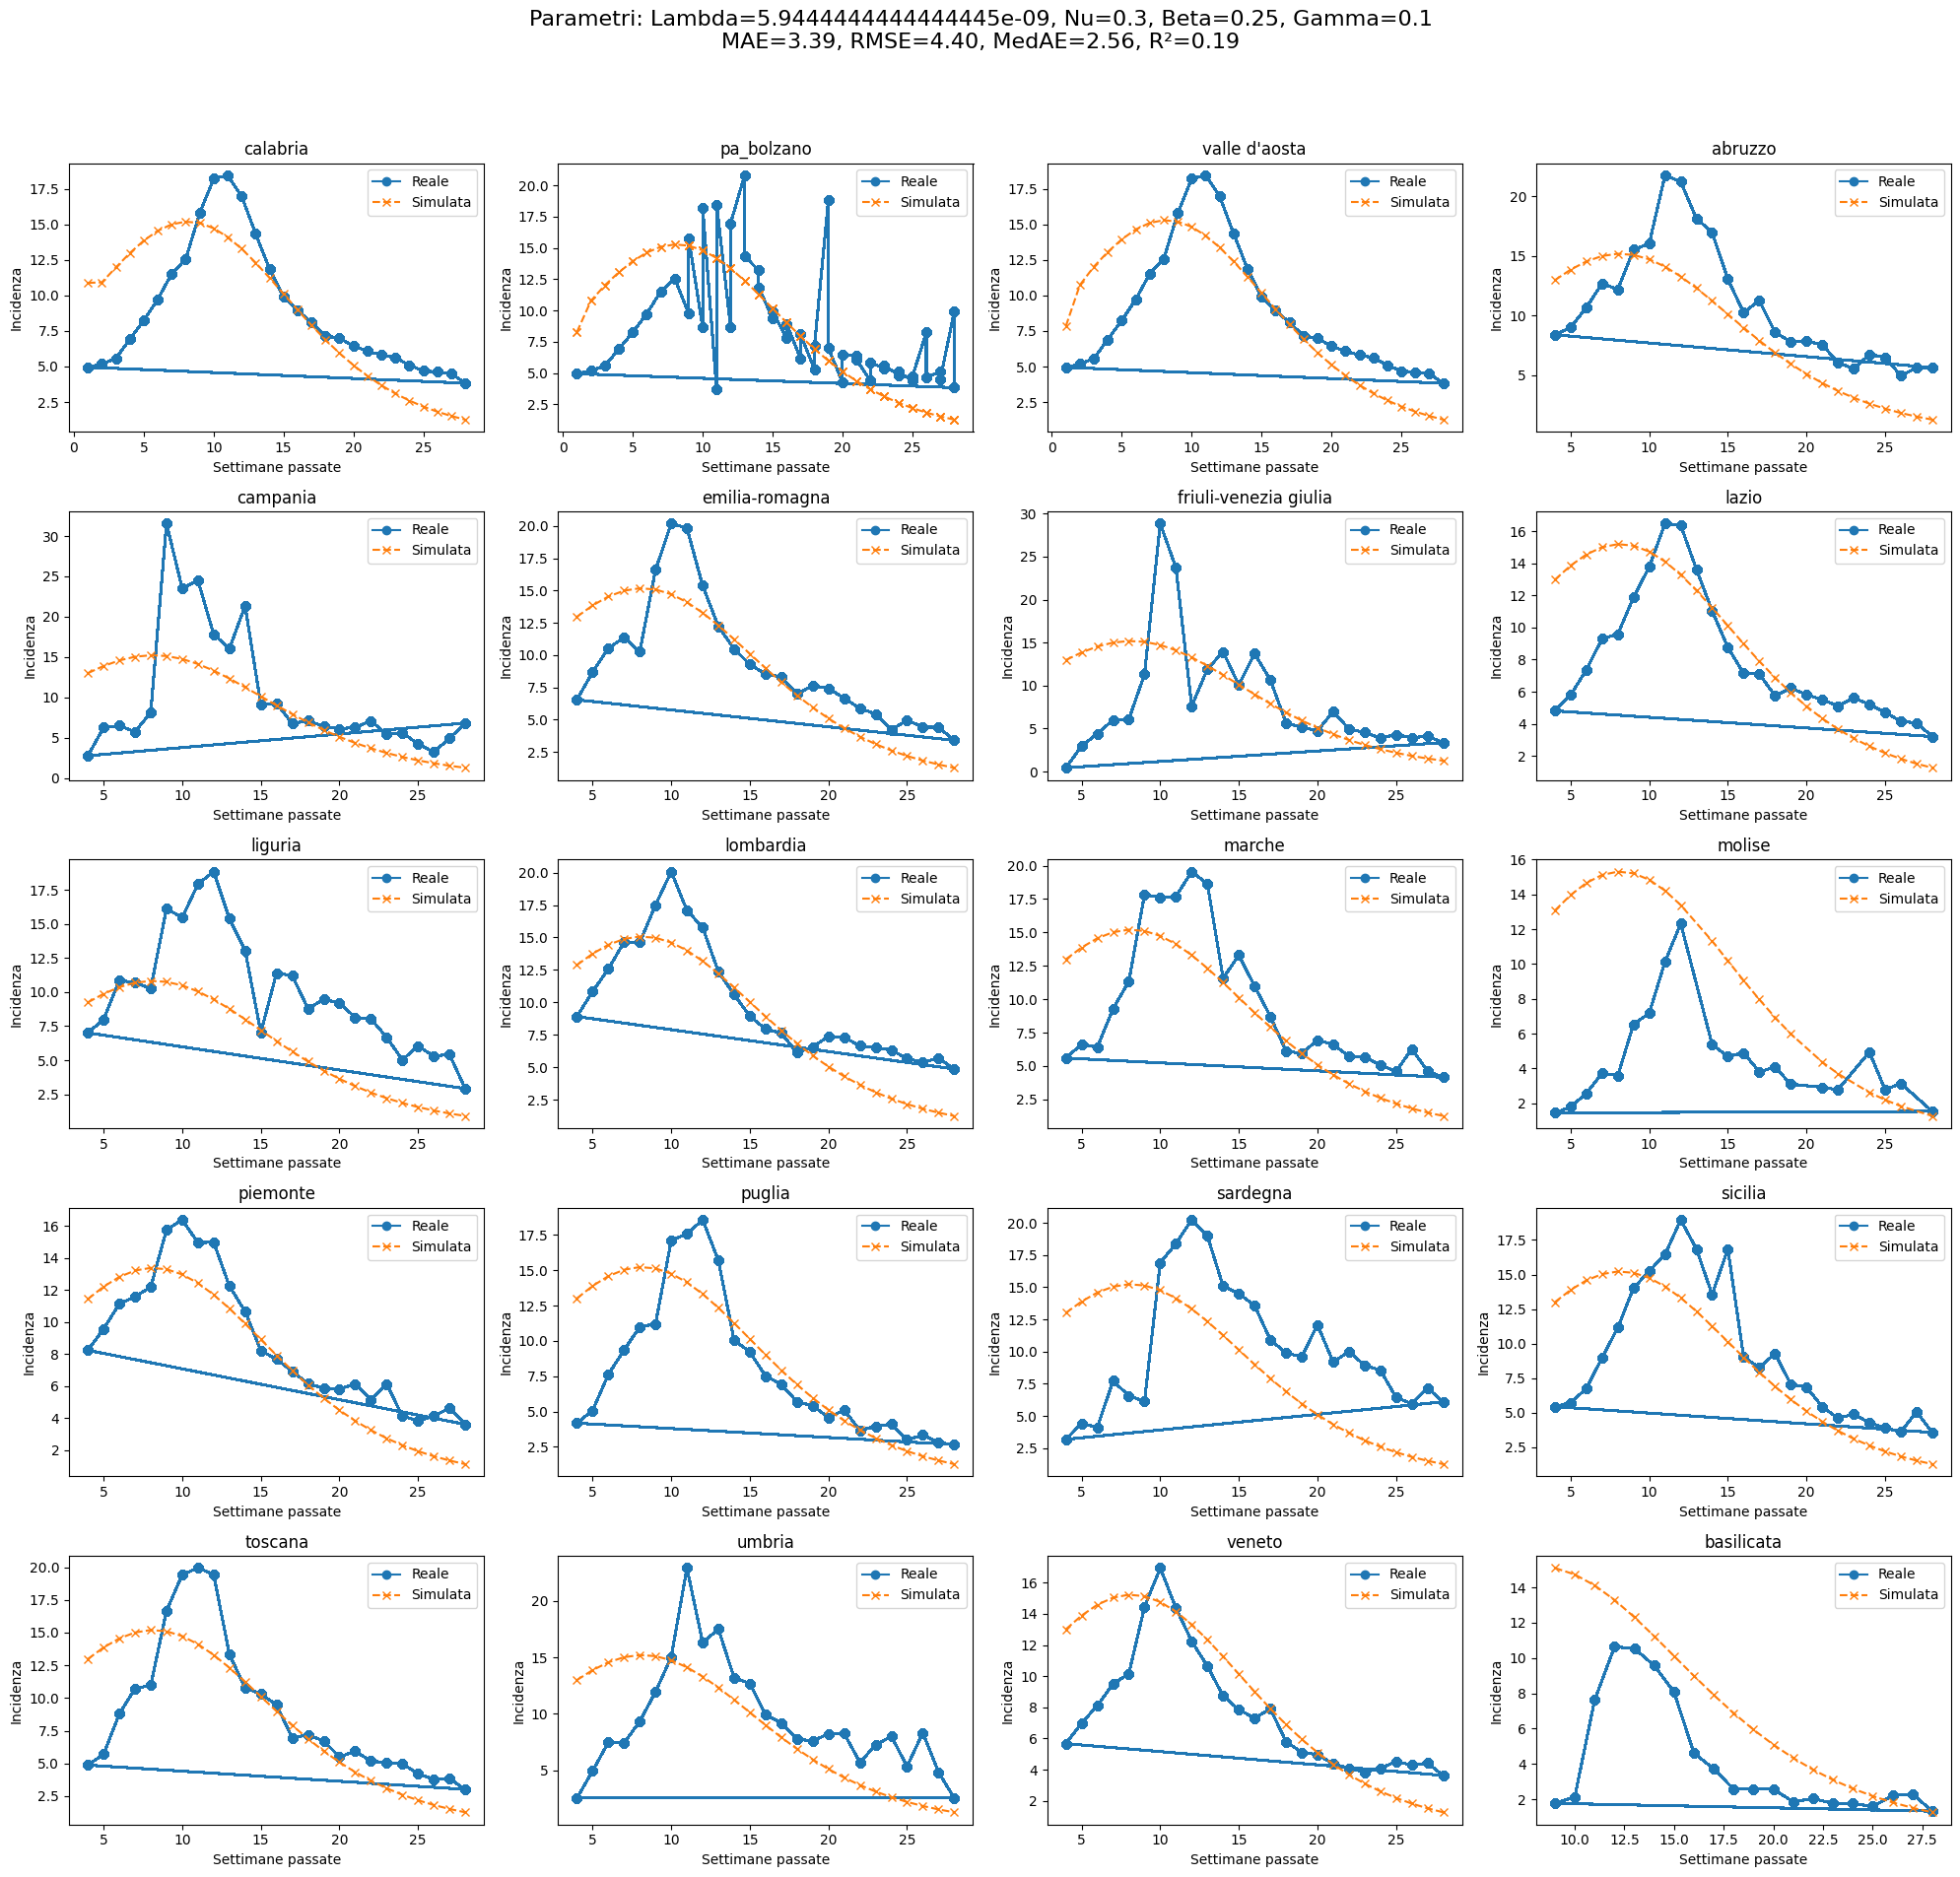

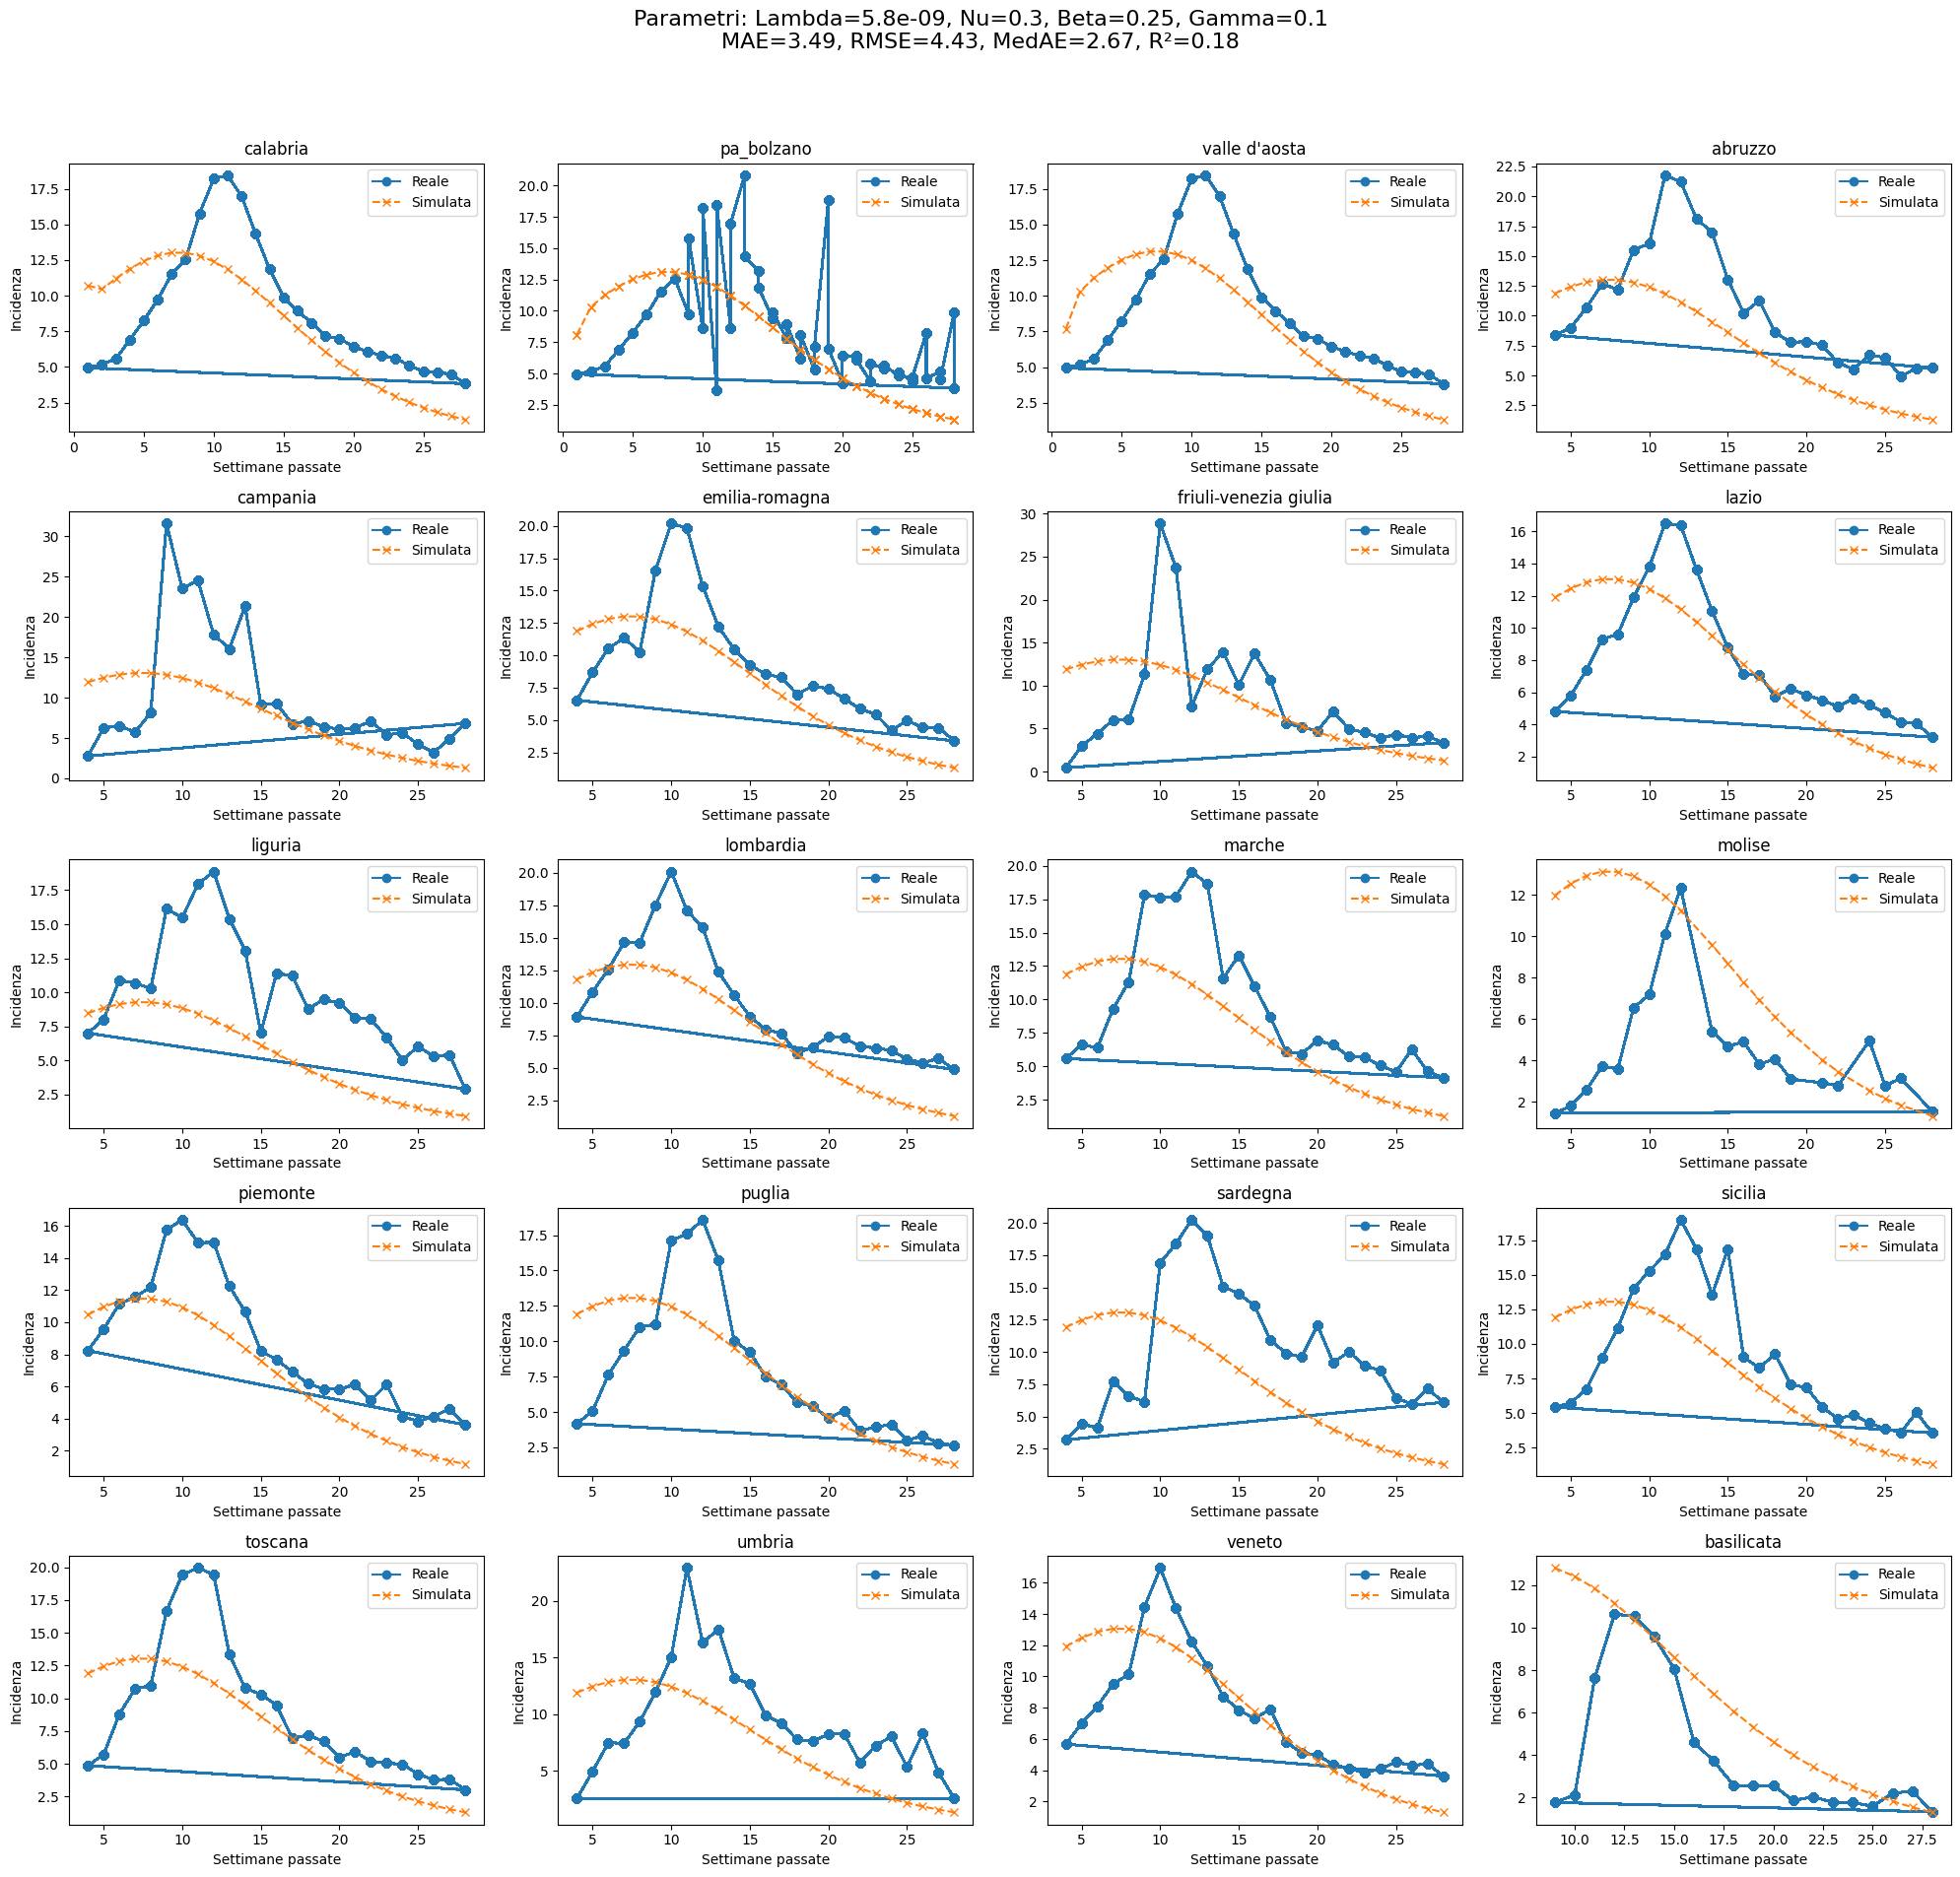

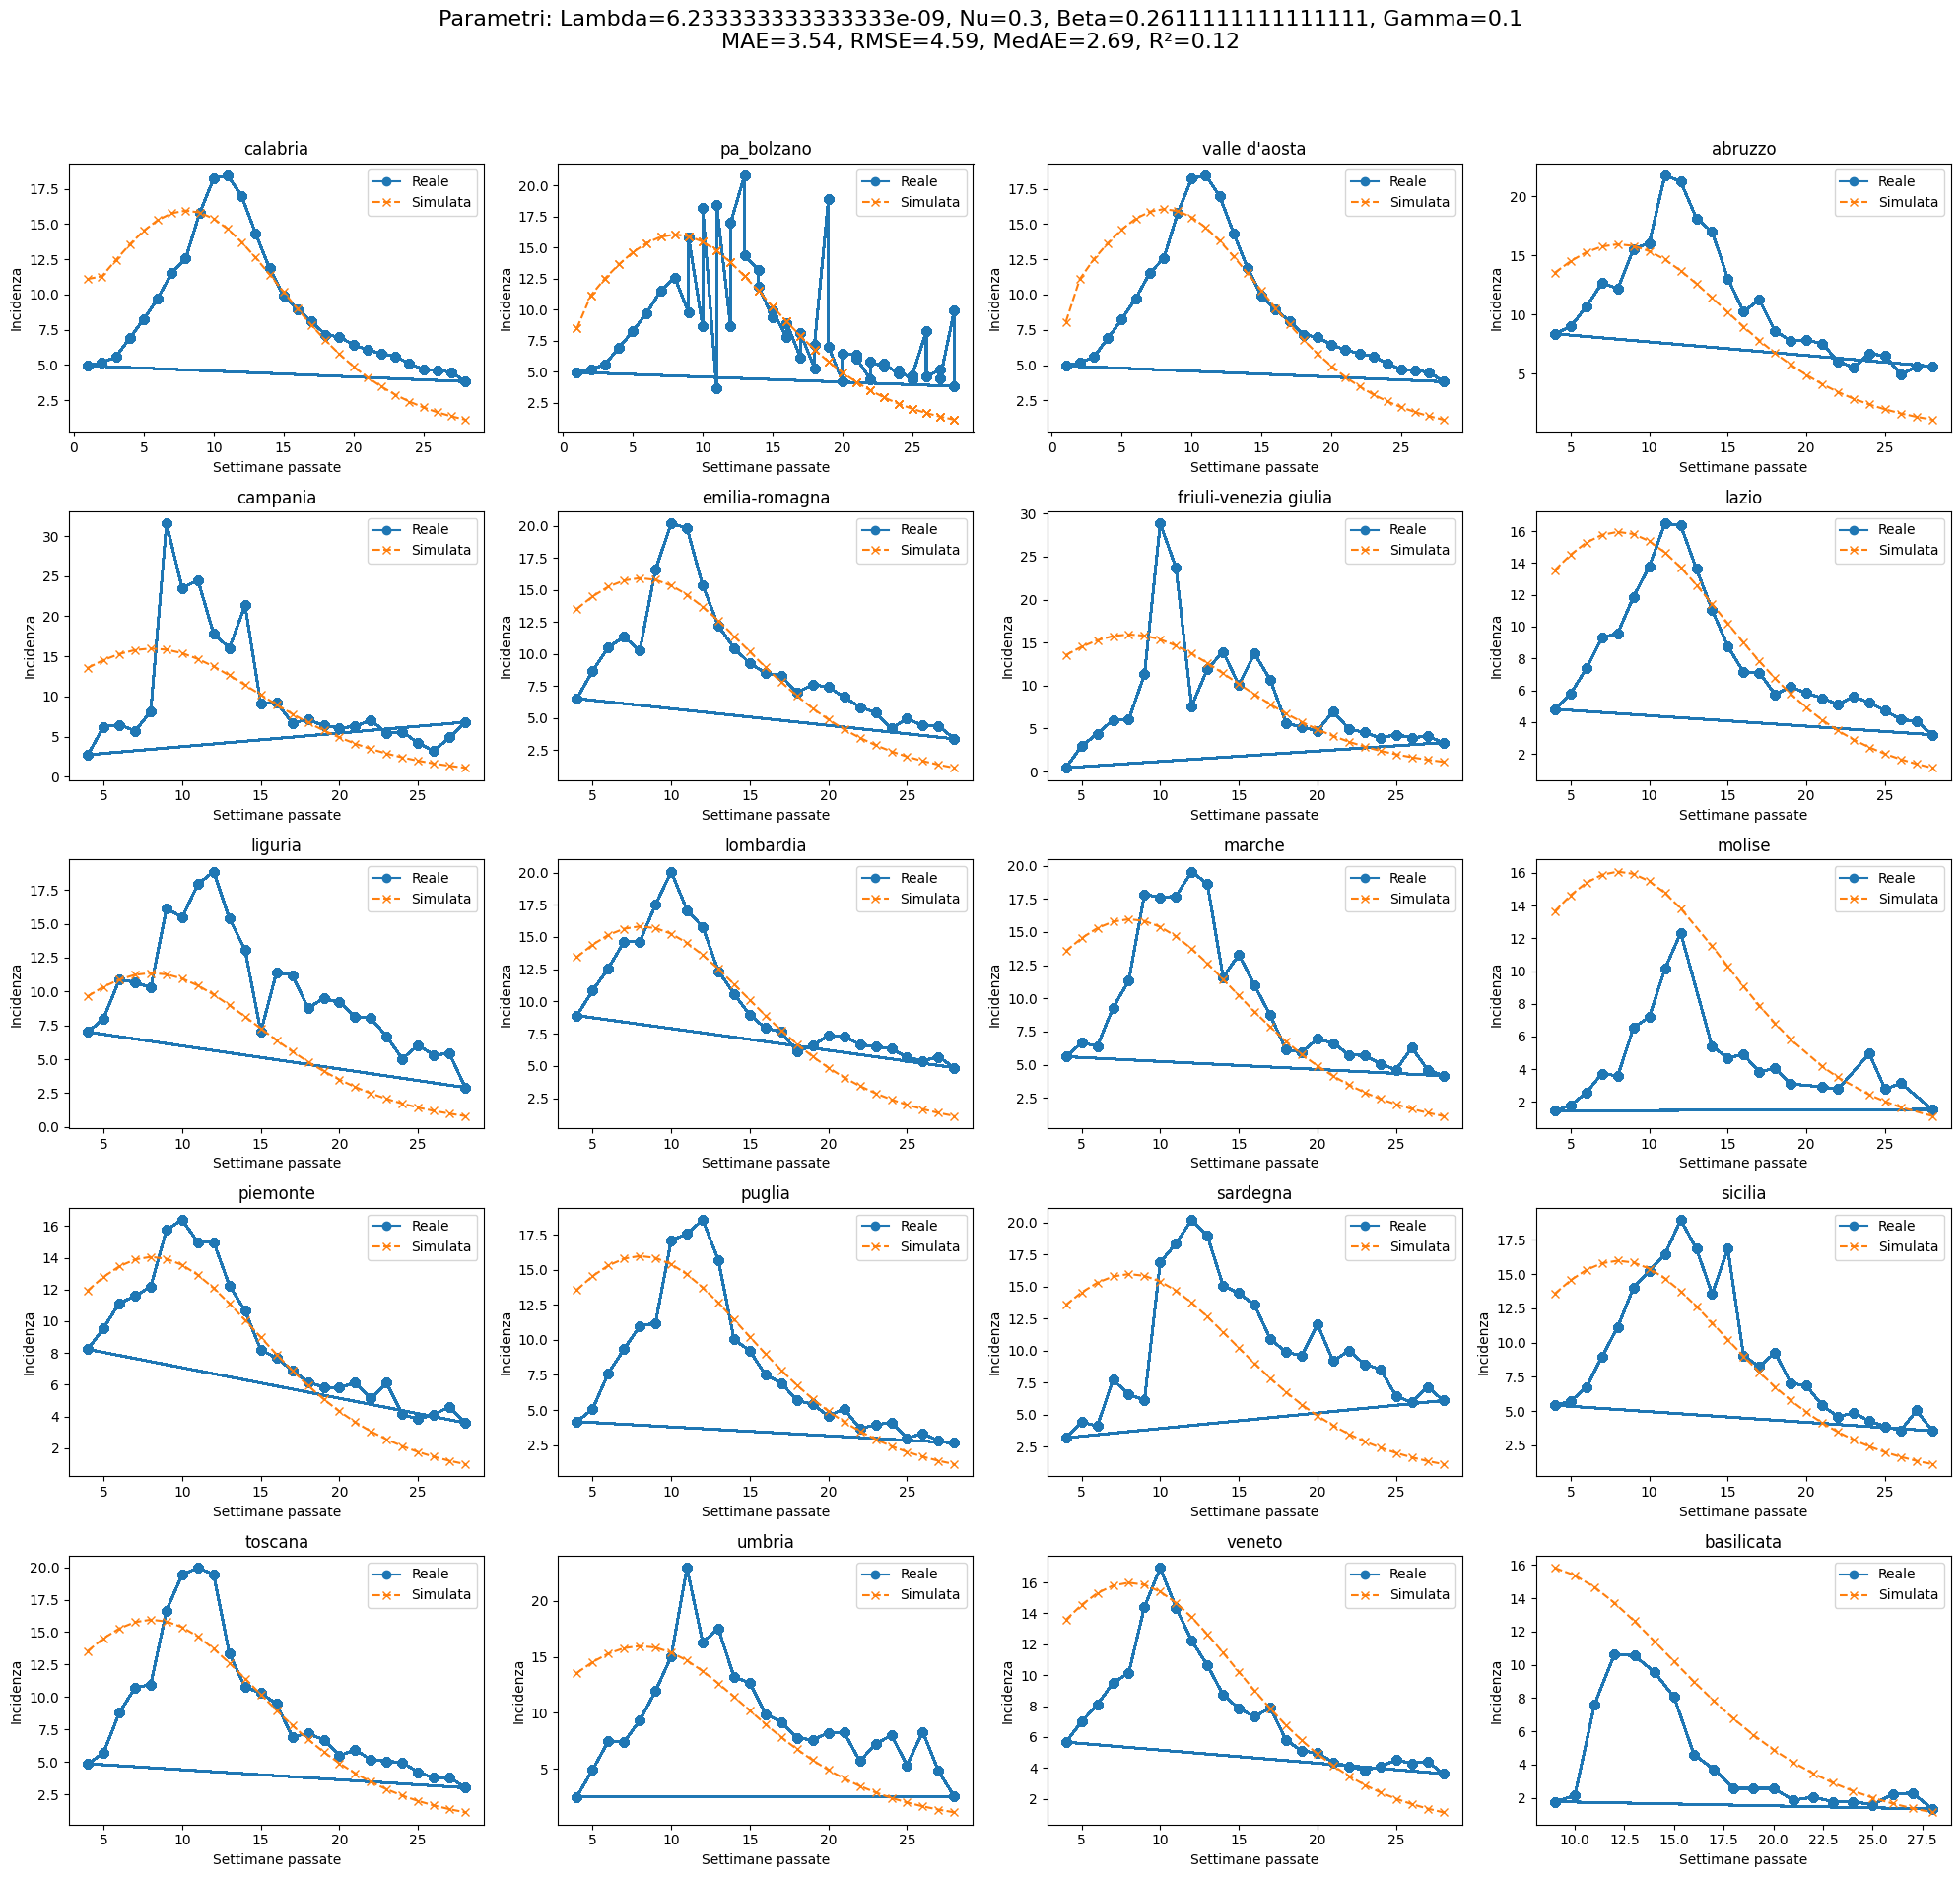

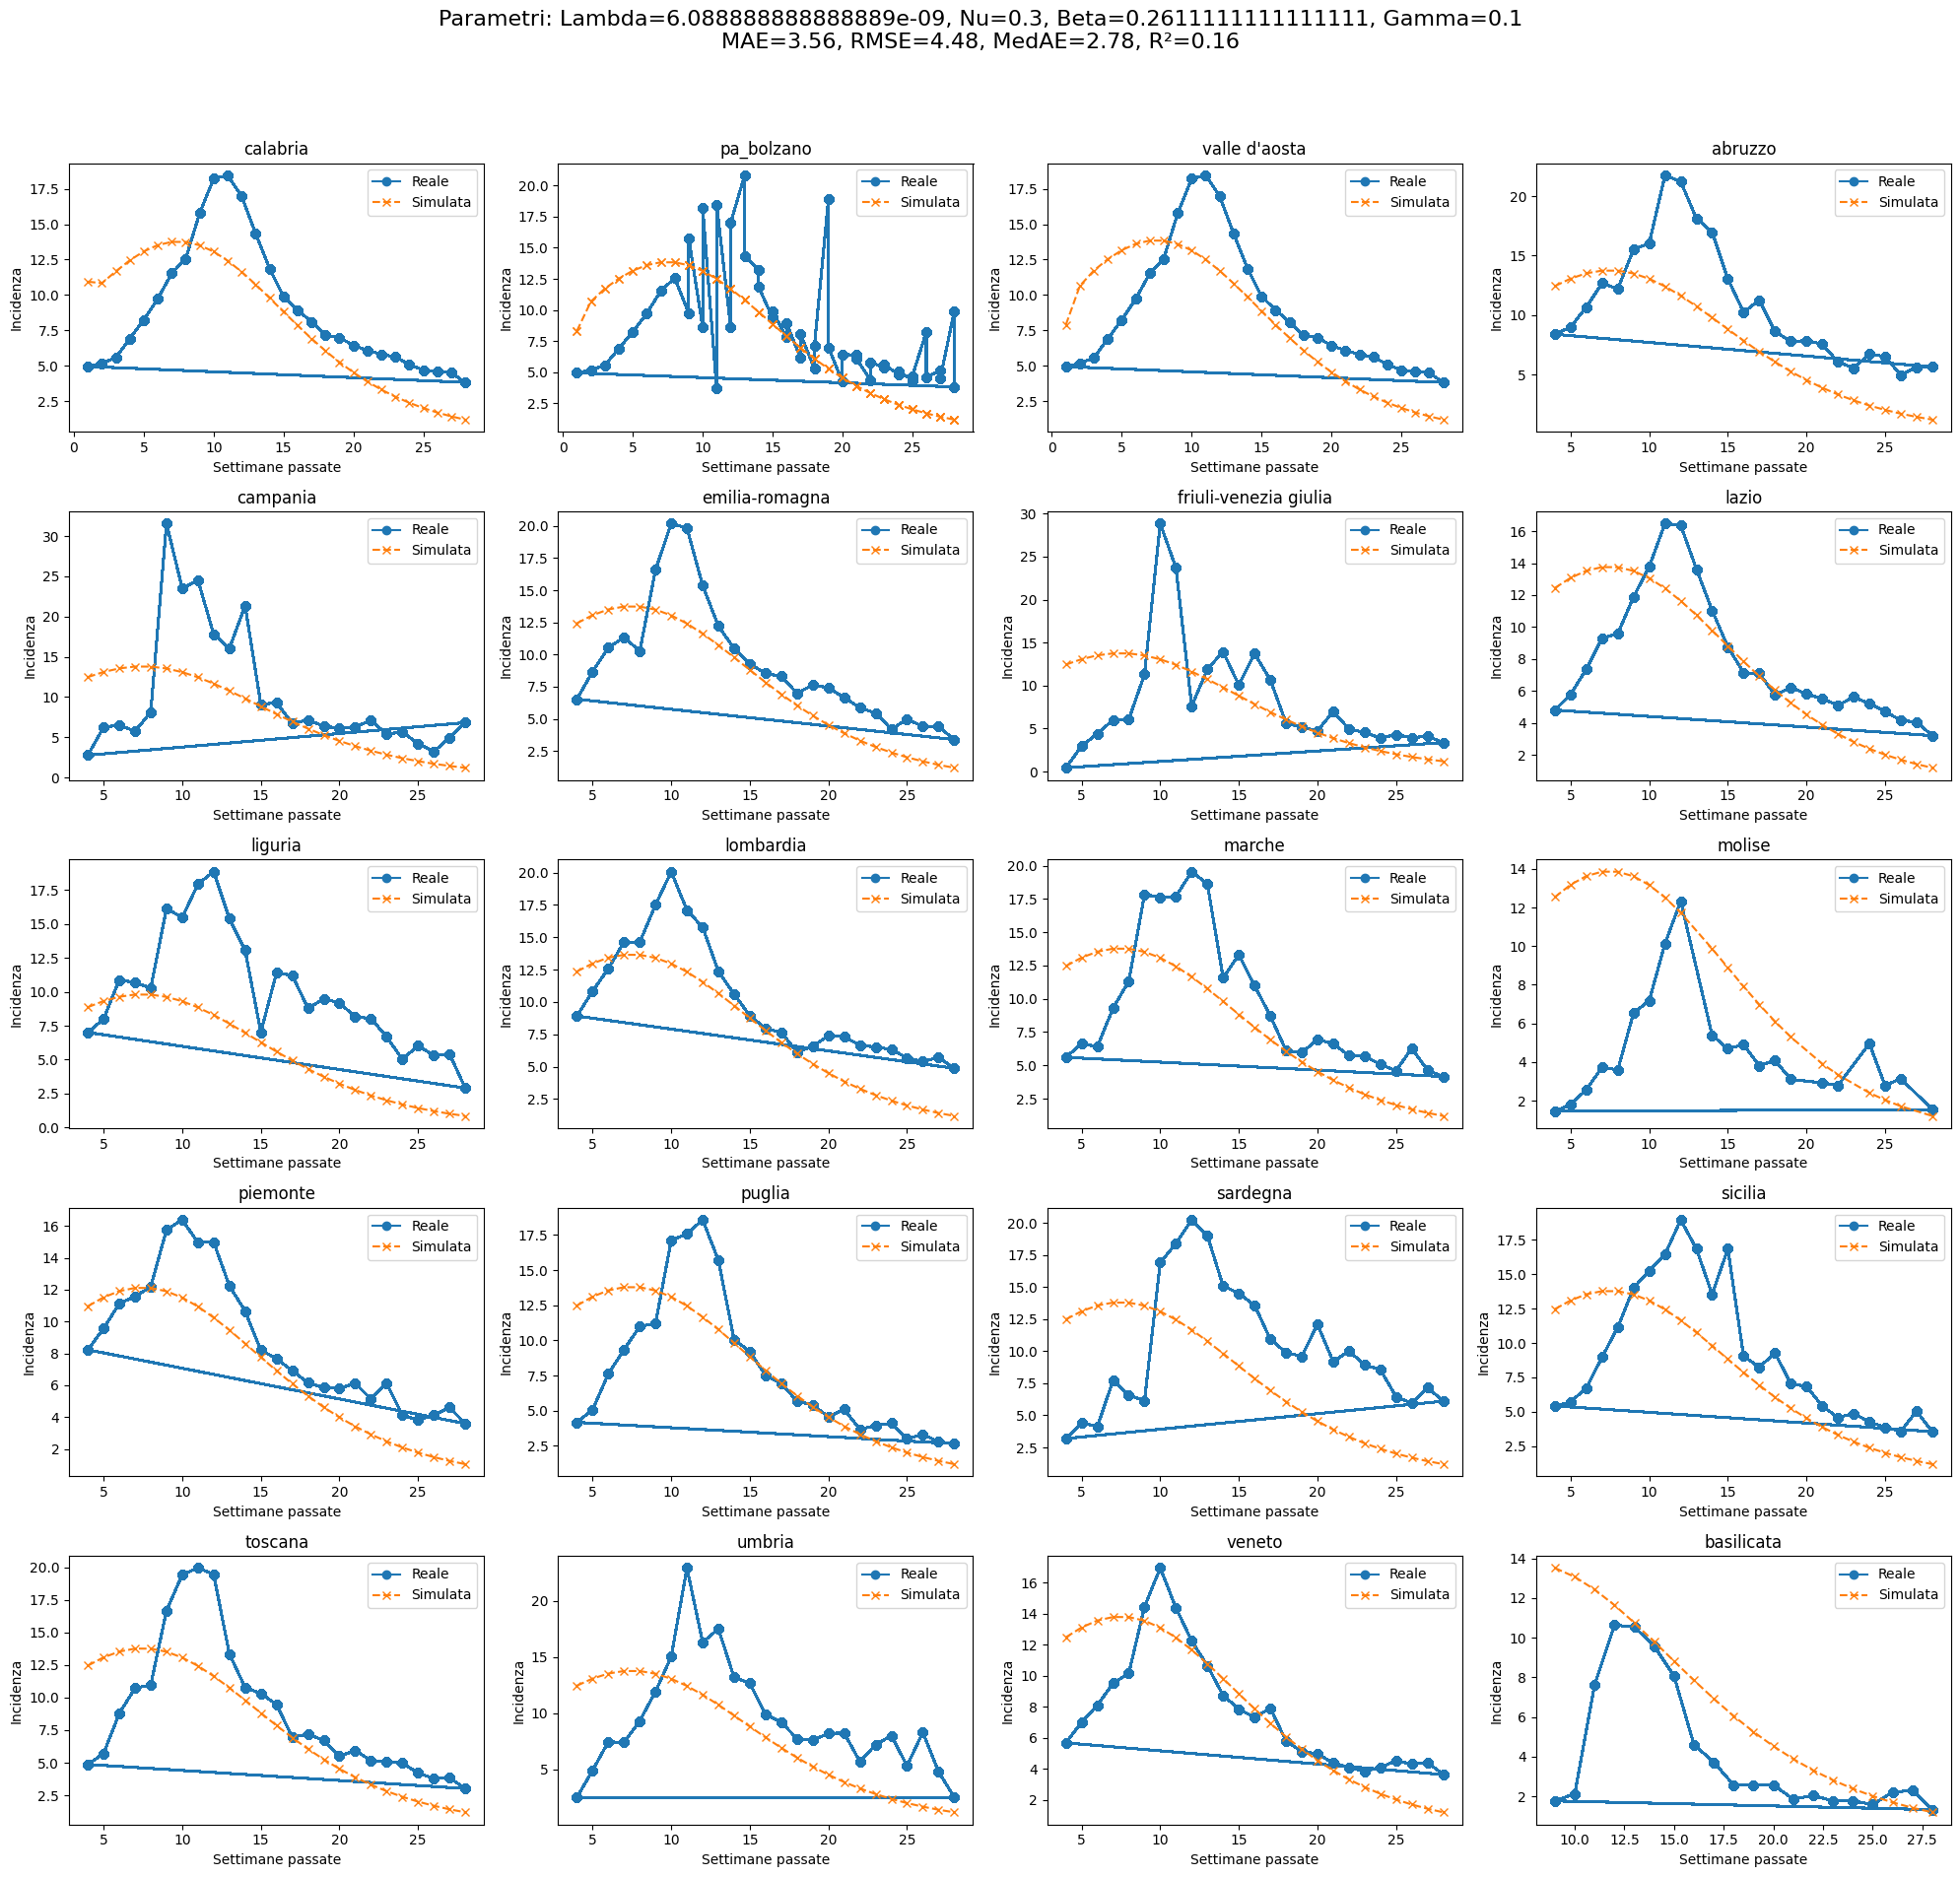

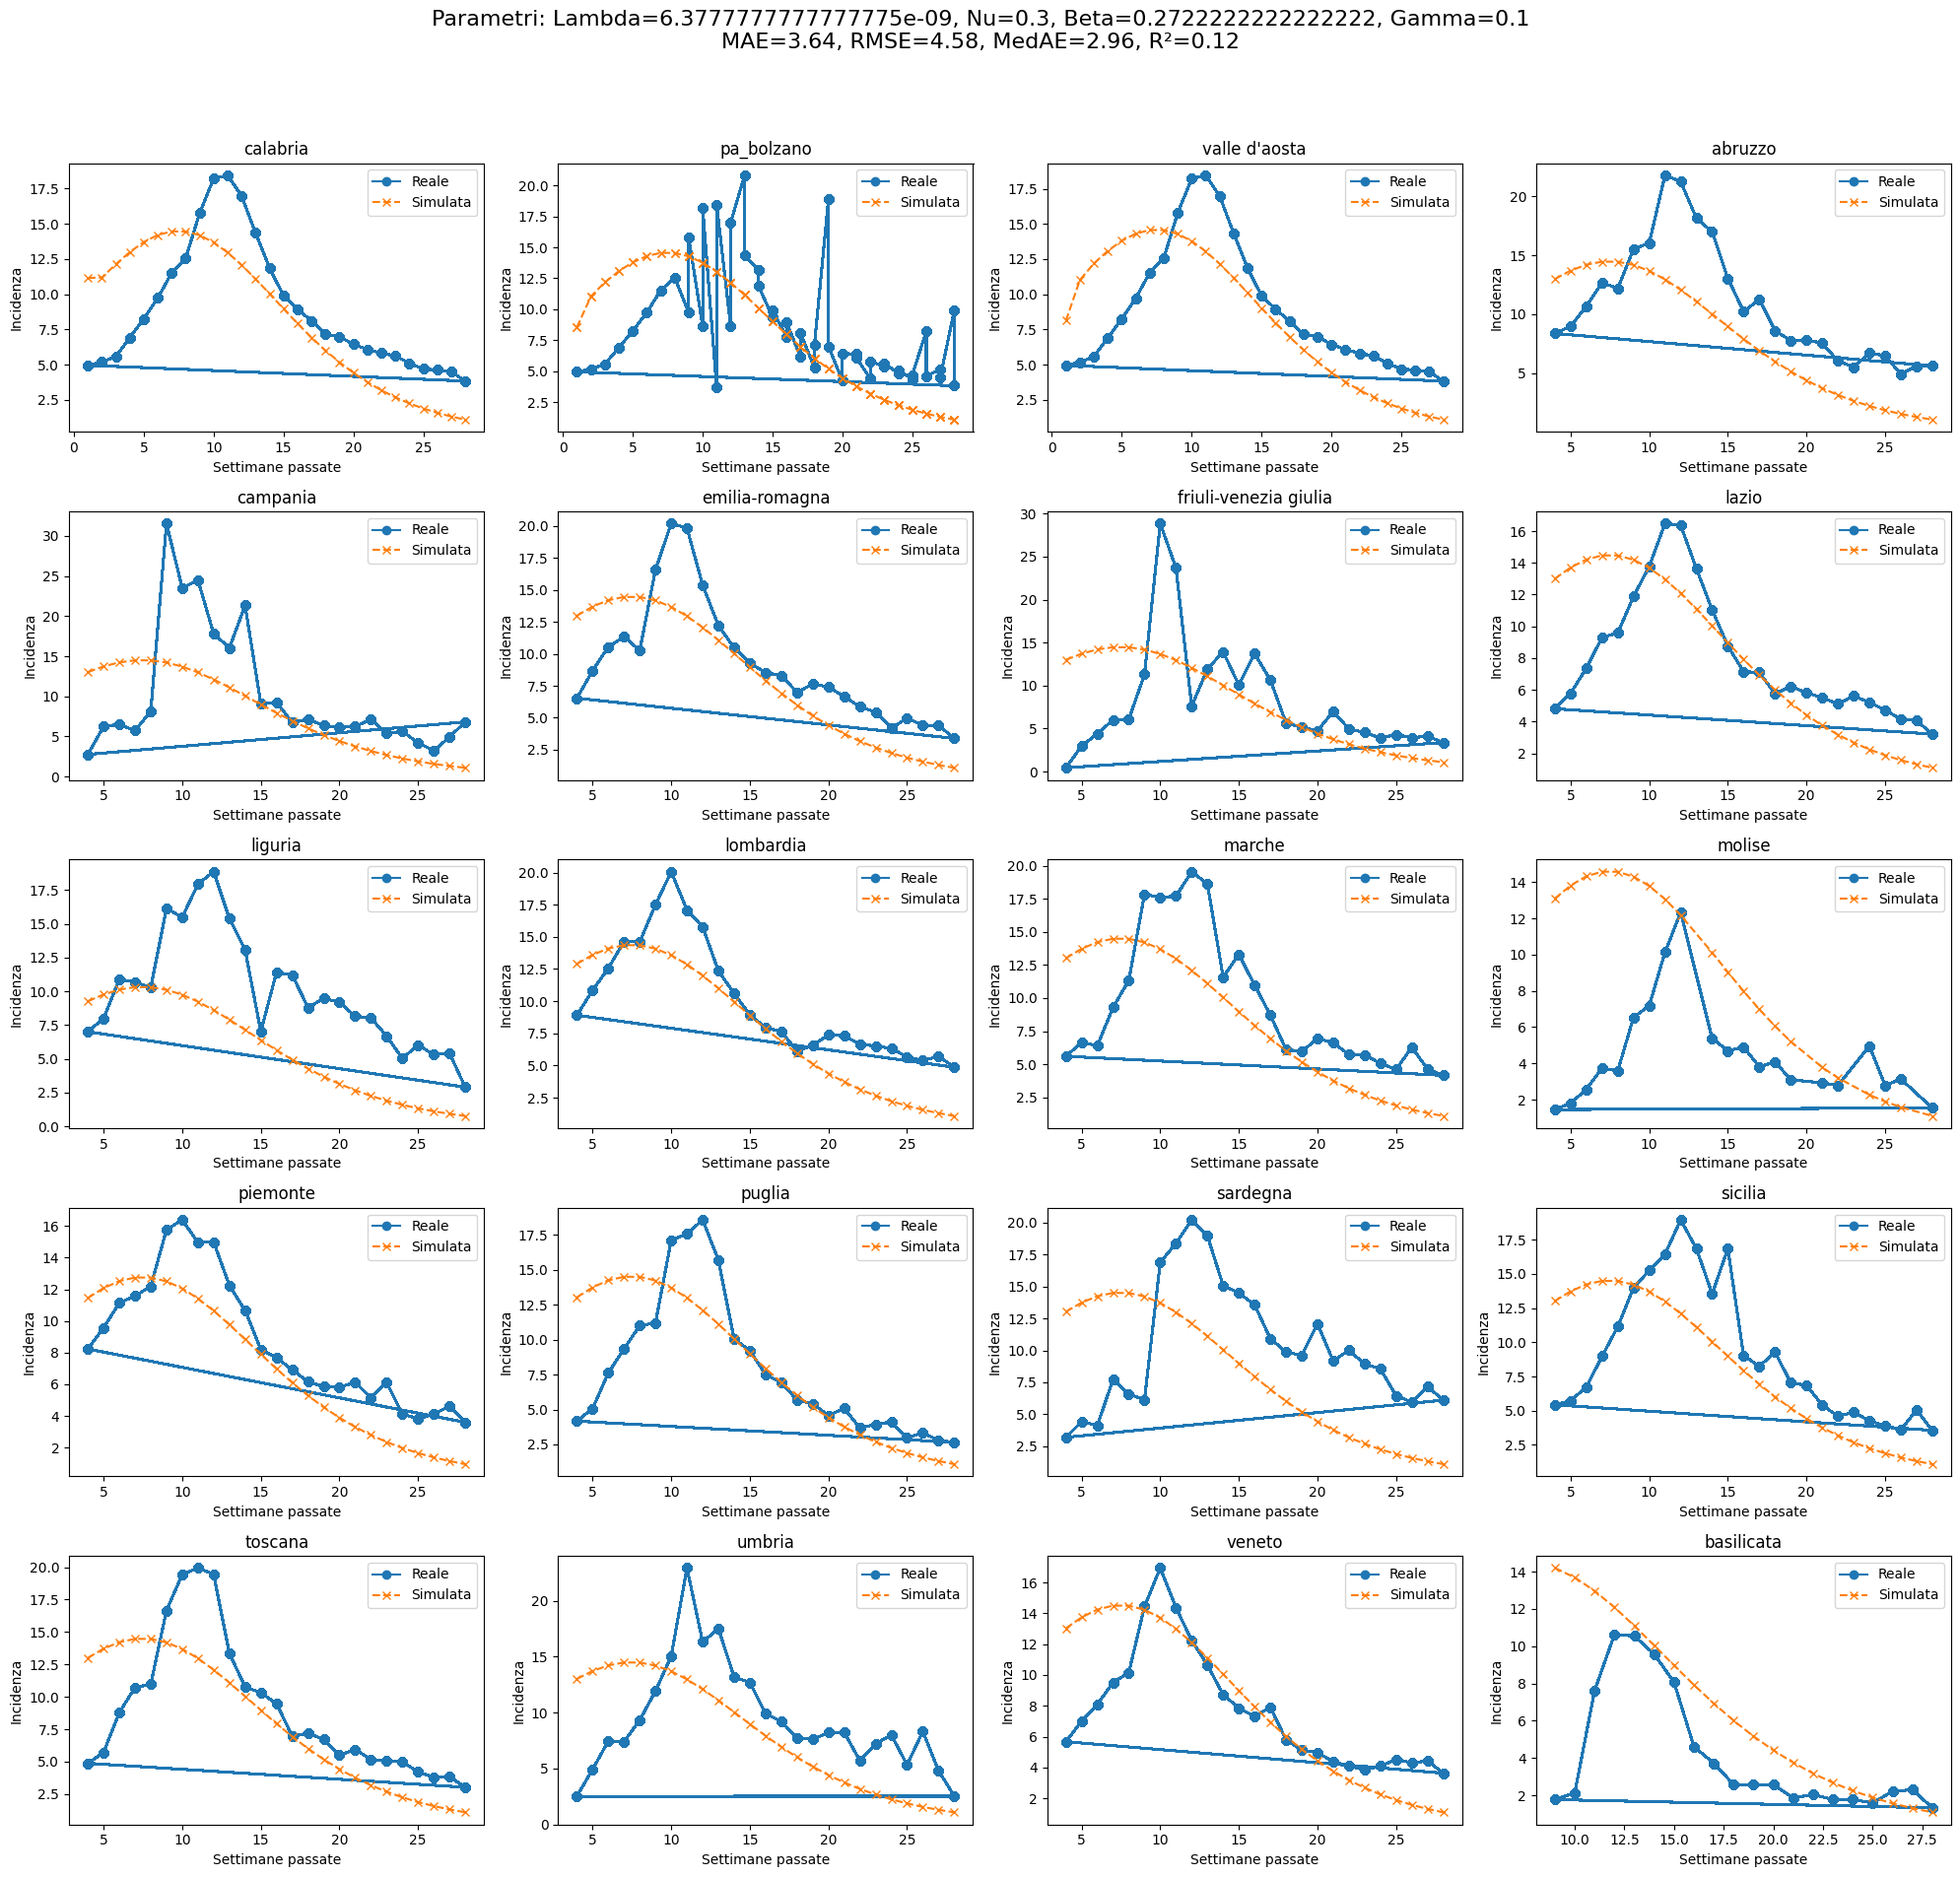

In [ ]:
import matplotlib.pyplot as plt

plots_per_row = 4  

for i, row in errori_ordinati.head(5).iterrows():
    lam, nu, beta, gamma = row['Lambda'], row['Nu'], row['Beta'], row['Gamma']
    mae, rmse, medae, r2 = row['MAE'], row['RMSE'], row['MedAE'], row['R2']
    # Filtra i dati simulati per questa combinazione
    df_simulazione = df_confronto[
        (df_confronto['Lambda'] == lam) & 
        (df_confronto['Nu'] == nu) & 
        (df_confronto['Beta'] == beta) & 
        (df_confronto['Gamma'] == gamma)
    ]
    
    unique_regions = df_confronto['regione'].unique()
    num_regions = len(unique_regions)
    rows = (num_regions + plots_per_row - 1) // plots_per_row  # Calcola quante righe servono
    
    fig, axes = plt.subplots(rows, plots_per_row, figsize=(plots_per_row * 5, rows * 4))
    
    axes = axes.flatten()  

    for idx, regione in enumerate(unique_regions):
        real_data = df_confronto[df_confronto['regione'] == regione]
        simulated_data = df_simulazione[df_simulazione['regione'] == regione]
        
        if real_data.empty or simulated_data.empty:
            continue
        
        ax = axes[idx]
        ax.plot(real_data['settimana_relativa'], real_data['incidenza_reale'], label='Reale', marker='o', linestyle='-')
        ax.plot(simulated_data['settimana_relativa'], simulated_data['incidenza_simulata'], label='Simulata', marker='x', linestyle='--')
        ax.set_title(f"{regione}")
        ax.set_xlabel("Settimane passate")
        ax.set_ylabel("Incidenza")
        ax.legend()
    
    for ax in axes[num_regions:]:
        ax.axis('off')
    
    fig.suptitle(f"Parametri: Lambda={lam}, Nu={nu}, Beta={beta}, Gamma={gamma}\n"
                 f"MAE={mae:.2f}, RMSE={rmse:.2f}, MedAE={medae:.2f}, R²={r2:.2f}", 
                 fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Aggiunge spazio per il titolo
    plt.show()
